#  Tutorial:RNA+ADT+ATAC (3omics)

In this tutorial, we will show how to cluster RNA+ADT+ATAC(3omics) data using scMAGCA. We use a processed human peripheral blood mononuclear sample dataset 'GSE158013' containing 7084 cells with three omics. Among them, ADT has 46 features, ATAC includes 2500 features and RNA contains 15000 features.

## Loading package

In [1]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import random
import warnings
warnings.filterwarnings("ignore")

/home/zhouzeming/anaconda3/lib/python3.9/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==58.0.4 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from scMAGCA.preprocess import read_dataset, preprocess_dataset
from scMAGCA.utils import *
from scMAGCA.scMAGCA_3omics import scMultiCluster

In [3]:
# set seed
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

## Reading dataset

The required input files include: 
1) x1: protein abundance matrix (data format is h5ad file) : GSE158013_adt.h5ad;\
2) x2: Chromatin accessibility matrix (data format is h5ad file) : GSE158013_atac.h5ad;\
3) x3: Gene expression matrix (data format is h5ad file) : GSE158013_rna.h5ad.

To ensure reproducibility of the results, please read the above data as follows:

In [12]:
x1 = sc.read_h5ad('../datasets/GSE158013/GSE158013_adt.h5ad').layers['counts']
feature1 = sc.read_h5ad('../datasets/GSE158013/GSE158013_adt.h5ad').var.index
x2 = sc.read_h5ad('../datasets/GSE158013/GSE158013_atac.h5ad').layers['counts'].A
feature2 = sc.read_h5ad('../datasets/GSE158013/GSE158013_atac.h5ad').var.index
x3 = sc.read_h5ad('../datasets/GSE158013/GSE158013_rna.h5ad').layers['counts'].A
feature3 = sc.read_h5ad('../datasets/GSE158013/GSE158013_rna.h5ad').var.index
y = None

In [13]:
x1,x2,x3

(array([[ 1.,  1., 15., ...,  0., 22., 44.],
        [30.,  3., 14., ...,  1., 20., 65.],
        [ 2.,  1., 17., ...,  1., 18., 37.],
        ...,
        [ 0.,  2., 12., ..., 31., 15., 30.],
        [ 0.,  0.,  8., ...,  1., 22., 35.],
        [ 0.,  0., 18., ...,  0., 24., 44.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[ 0.,  0.,  0., ...,  0., 14., 28.],
        [ 0.,  0.,  1., ...,  0., 15., 24.],
        [ 0.,  0.,  1., ...,  0., 19., 33.],
        ...,
        [ 0.,  0.,  0., ...,  0., 15., 56.],
        [ 0.,  0.,  0., ...,  0., 19., 49.],
        [ 0.,  0.,  5., ...,  0., 23., 25.]], dtype=float32))

We select the ATAC and RNA omics for high expression, and the number of chosen features are both set to 2000.

Chosen offset: 1.11
Chosen offset: 0.17


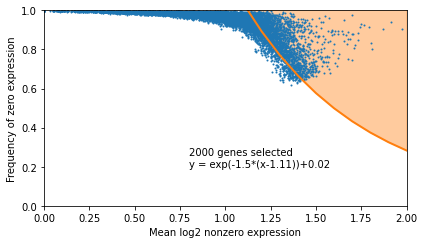

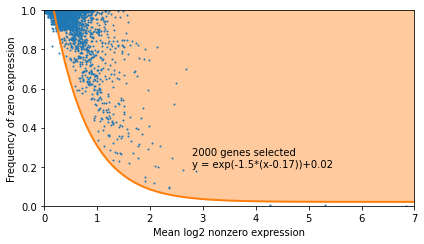

In [14]:
importantGenes = geneSelection(x2, n=2000)
x2 = x2[:, importantGenes]
feature2 = feature2[importantGenes]
importantGenes = geneSelection(x3, n=2000)
x3 = x3[:, importantGenes]
feature3 = feature3[importantGenes]

In [15]:
adata1 = sc.AnnData(x1)
adata1 = read_dataset(adata1, copy=True)
adata1 = preprocess_dataset(adata1, normalize_input=True, logtrans_input=True)
adata1.var['importantGenes'] = feature1

### Autoencoder: Successfully preprocessed 46 features and 7084 cells.


In [16]:
adata1

AnnData object with n_obs × n_vars = 7084 × 46
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std', 'importantGenes'
    uns: 'log1p'

In [17]:
adata2 = sc.AnnData(x2)
adata2 = read_dataset(adata2, copy=True)
adata2 = preprocess_dataset(adata2, normalize_input=True, logtrans_input=True)
adata2.var['importantGenes'] = feature2

### Autoencoder: Successfully preprocessed 2000 features and 7084 cells.


In [18]:
adata2

AnnData object with n_obs × n_vars = 7084 × 2000
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std', 'importantGenes'
    uns: 'log1p'

In [19]:
adata3 = sc.AnnData(x3)
adata3 = read_dataset(adata3, copy=True)
adata3 = preprocess_dataset(adata3, normalize_input=True, logtrans_input=True)
adata3.var['importantGenes'] = feature3

### Autoencoder: Successfully preprocessed 2000 features and 7084 cells.


In [20]:
adata3

AnnData object with n_obs × n_vars = 7084 × 2000
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std', 'importantGenes'
    uns: 'log1p'

## Training the model

In [21]:
model = scMultiCluster(input_dim1=adata1.n_vars,input_dim2=adata2.n_vars,input_dim3=adata3.n_vars,device='cuda').to('cuda')

In [22]:
model

scMultiCluster(
  (encoder): Encoder(
    (stacked_gnn): ModuleList(
      (0): GCNConv(4046, 1024)
      (1): GCNConv(1024, 256)
      (2): GCNConv(256, 64)
      (3): GCNConv(64, 32)
    )
    (stacked_bns): ModuleList(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (3): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
    (stacked_prelus): ModuleList(
      (0-3): 4 x PReLU(num_parameters=1)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, moment

In [24]:
pretrain_latent = model.pretrain_autoencoder(
                        X1=adata1.X, X2=adata2.X, X3=adata3.X, 
                        X1_raw=adata1.raw.X, X2_raw=adata2.raw.X, X3_raw=adata3.raw.X,
                        epochs=400, file='GSE158013')

Pretraining stage


Processing...


Processing full batch data


Done!


Pretrain epoch 1, recon_loss:1.175199, zinb_loss:0.855500, adversial_loss:1.378395
Pretrain epoch 2, recon_loss:1.108052, zinb_loss:0.790036, adversial_loss:1.353847
Pretrain epoch 3, recon_loss:1.013116, zinb_loss:0.732100, adversial_loss:1.349079
Pretrain epoch 4, recon_loss:0.967926, zinb_loss:0.685367, adversial_loss:1.347783
Pretrain epoch 5, recon_loss:0.955065, zinb_loss:0.643808, adversial_loss:1.350997
Pretrain epoch 6, recon_loss:0.948277, zinb_loss:0.607989, adversial_loss:1.351554
Pretrain epoch 7, recon_loss:0.940977, zinb_loss:0.578766, adversial_loss:1.349777
Pretrain epoch 8, recon_loss:0.933745, zinb_loss:0.558008, adversial_loss:1.347673
Pretrain epoch 9, recon_loss:0.928594, zinb_loss:0.546180, adversial_loss:1.345650
Pretrain epoch 10, recon_loss:0.924947, zinb_loss:0.540460, adversial_loss:1.343964
Pretrain epoch 11, recon_loss:0.921956, zinb_loss:0.537047, adversial_loss:1.342250
Pretrain epoch 12, recon_loss:0.919373, zinb_loss:0.533806, adversial_loss:1.340244
P

Pretrain epoch 101, recon_loss:0.876652, zinb_loss:0.473544, adversial_loss:1.271894
Pretrain epoch 102, recon_loss:0.876898, zinb_loss:0.473643, adversial_loss:1.271924
Pretrain epoch 103, recon_loss:0.876329, zinb_loss:0.473405, adversial_loss:1.270079
Pretrain epoch 104, recon_loss:0.876395, zinb_loss:0.473419, adversial_loss:1.269913
Pretrain epoch 105, recon_loss:0.876021, zinb_loss:0.473242, adversial_loss:1.271329
Pretrain epoch 106, recon_loss:0.876009, zinb_loss:0.473213, adversial_loss:1.269614
Pretrain epoch 107, recon_loss:0.875709, zinb_loss:0.473094, adversial_loss:1.269238
Pretrain epoch 108, recon_loss:0.875638, zinb_loss:0.473099, adversial_loss:1.269217
Pretrain epoch 109, recon_loss:0.875589, zinb_loss:0.473085, adversial_loss:1.270183
Pretrain epoch 110, recon_loss:0.875630, zinb_loss:0.472942, adversial_loss:1.268777
Pretrain epoch 111, recon_loss:0.875412, zinb_loss:0.472890, adversial_loss:1.269828
Pretrain epoch 112, recon_loss:0.875219, zinb_loss:0.472672, adve

Pretrain epoch 201, recon_loss:0.863801, zinb_loss:0.469539, adversial_loss:1.252052
Pretrain epoch 202, recon_loss:0.863201, zinb_loss:0.469408, adversial_loss:1.251682
Pretrain epoch 203, recon_loss:0.863240, zinb_loss:0.469417, adversial_loss:1.252034
Pretrain epoch 204, recon_loss:0.863252, zinb_loss:0.469381, adversial_loss:1.251441
Pretrain epoch 205, recon_loss:0.862742, zinb_loss:0.469278, adversial_loss:1.251415
Pretrain epoch 206, recon_loss:0.862873, zinb_loss:0.469293, adversial_loss:1.251901
Pretrain epoch 207, recon_loss:0.862636, zinb_loss:0.469266, adversial_loss:1.251052
Pretrain epoch 208, recon_loss:0.862264, zinb_loss:0.469171, adversial_loss:1.251126
Pretrain epoch 209, recon_loss:0.862361, zinb_loss:0.469184, adversial_loss:1.251550
Pretrain epoch 210, recon_loss:0.861932, zinb_loss:0.469147, adversial_loss:1.250322
Pretrain epoch 211, recon_loss:0.861820, zinb_loss:0.469102, adversial_loss:1.250784
Pretrain epoch 212, recon_loss:0.861814, zinb_loss:0.469097, adve

Pretrain epoch 301, recon_loss:0.850727, zinb_loss:0.467927, adversial_loss:1.243152
Pretrain epoch 302, recon_loss:0.850798, zinb_loss:0.467961, adversial_loss:1.242474
Pretrain epoch 303, recon_loss:0.850198, zinb_loss:0.467831, adversial_loss:1.242292
Pretrain epoch 304, recon_loss:0.849208, zinb_loss:0.467715, adversial_loss:1.243224
Pretrain epoch 305, recon_loss:0.849883, zinb_loss:0.467866, adversial_loss:1.241327
Pretrain epoch 306, recon_loss:0.849987, zinb_loss:0.467795, adversial_loss:1.242927
Pretrain epoch 307, recon_loss:0.849103, zinb_loss:0.467620, adversial_loss:1.241711
Pretrain epoch 308, recon_loss:0.849738, zinb_loss:0.467722, adversial_loss:1.241875
Pretrain epoch 309, recon_loss:0.849819, zinb_loss:0.467710, adversial_loss:1.241883
Pretrain epoch 310, recon_loss:0.849205, zinb_loss:0.467607, adversial_loss:1.242167
Pretrain epoch 311, recon_loss:0.849304, zinb_loss:0.467682, adversial_loss:1.241405
Pretrain epoch 312, recon_loss:0.849002, zinb_loss:0.467620, adve

In [25]:
y_pred, final_latent = model.fit(y=y, n_clusters=-1, num_epochs=2000, file='GSE158013',pretrain_latent=pretrain_latent)

Clustering stage
Estimated n_clusters is:  7
Initializing cluster centers with kmeans.
Initializing k-means: ASW= 0.4344, DB= 0.9470, CH= 4032.3028
Training epoch 1, recon_loss:0.832919, zinb_loss:0.466575, cluster_loss:0.207182
Clustering   1: ASW= 0.4344, DB= 0.9470, CH= 4032.3028
Training epoch 2, recon_loss:0.887874, zinb_loss:0.473593, cluster_loss:0.212438
Clustering   2: ASW= 0.5285, DB= 0.7033, CH= 7507.6300
Training epoch 3, recon_loss:0.913830, zinb_loss:0.476516, cluster_loss:0.226155
Clustering   3: ASW= 0.5506, DB= 0.6721, CH= 7760.1150
Training epoch 4, recon_loss:0.897848, zinb_loss:0.476857, cluster_loss:0.211880
Clustering   4: ASW= 0.5716, DB= 0.6261, CH= 9449.4753
Training epoch 5, recon_loss:0.895170, zinb_loss:0.474653, cluster_loss:0.212168
Clustering   5: ASW= 0.6029, DB= 0.5841, CH= 9793.6500
Training epoch 6, recon_loss:0.895097, zinb_loss:0.475862, cluster_loss:0.204507
Clustering   6: ASW= 0.6064, DB= 0.5652, CH= 11096.5971
Training epoch 7, recon_loss:0.8960

Training epoch 60, recon_loss:0.894262, zinb_loss:0.480159, cluster_loss:0.173799
Clustering   60: ASW= 0.7490, DB= 0.3448, CH= 23987.2433
Training epoch 61, recon_loss:0.895237, zinb_loss:0.480413, cluster_loss:0.174413
Clustering   61: ASW= 0.7522, DB= 0.3381, CH= 24290.5140
Training epoch 62, recon_loss:0.895414, zinb_loss:0.480332, cluster_loss:0.174617
Clustering   62: ASW= 0.7497, DB= 0.3440, CH= 24145.7464
Training epoch 63, recon_loss:0.895203, zinb_loss:0.480538, cluster_loss:0.174288
Clustering   63: ASW= 0.7535, DB= 0.3354, CH= 24563.4381
Training epoch 64, recon_loss:0.895713, zinb_loss:0.480397, cluster_loss:0.174410
Clustering   64: ASW= 0.7511, DB= 0.3422, CH= 24279.4558
Training epoch 65, recon_loss:0.896016, zinb_loss:0.480663, cluster_loss:0.174676
Clustering   65: ASW= 0.7551, DB= 0.3326, CH= 24814.4452
Training epoch 66, recon_loss:0.895584, zinb_loss:0.480459, cluster_loss:0.174344
Clustering   66: ASW= 0.7522, DB= 0.3407, CH= 24514.2996
Training epoch 67, recon_lo

Training epoch 119, recon_loss:0.893094, zinb_loss:0.481098, cluster_loss:0.168114
Clustering   119: ASW= 0.7732, DB= 0.3130, CH= 29007.3892
Training epoch 120, recon_loss:0.893008, zinb_loss:0.481034, cluster_loss:0.168699
Clustering   120: ASW= 0.7728, DB= 0.3180, CH= 28579.3903
Training epoch 121, recon_loss:0.893333, zinb_loss:0.481158, cluster_loss:0.168299
Clustering   121: ASW= 0.7737, DB= 0.3126, CH= 29056.7675
Training epoch 122, recon_loss:0.893283, zinb_loss:0.481080, cluster_loss:0.168843
Clustering   122: ASW= 0.7730, DB= 0.3183, CH= 28701.7644
Training epoch 123, recon_loss:0.893618, zinb_loss:0.481235, cluster_loss:0.168535
Clustering   123: ASW= 0.7742, DB= 0.3124, CH= 29095.0453
Training epoch 124, recon_loss:0.893566, zinb_loss:0.481138, cluster_loss:0.168963
Clustering   124: ASW= 0.7733, DB= 0.3172, CH= 28845.0855
Training epoch 125, recon_loss:0.893796, zinb_loss:0.481306, cluster_loss:0.168674
Clustering   125: ASW= 0.7745, DB= 0.3125, CH= 29120.5798
Training epoc

Training epoch 178, recon_loss:0.892422, zinb_loss:0.481615, cluster_loss:0.166583
Clustering   178: ASW= 0.7830, DB= 0.3022, CH= 31138.7196
Training epoch 179, recon_loss:0.892407, zinb_loss:0.481467, cluster_loss:0.166890
Clustering   179: ASW= 0.7829, DB= 0.3009, CH= 31637.0119
Training epoch 180, recon_loss:0.892806, zinb_loss:0.481647, cluster_loss:0.166786
Clustering   180: ASW= 0.7832, DB= 0.3016, CH= 31093.5441
Training epoch 181, recon_loss:0.892767, zinb_loss:0.481504, cluster_loss:0.167002
Clustering   181: ASW= 0.7829, DB= 0.3011, CH= 31748.2067
Training epoch 182, recon_loss:0.892773, zinb_loss:0.481636, cluster_loss:0.166807
Clustering   182: ASW= 0.7835, DB= 0.3010, CH= 31095.2856
Training epoch 183, recon_loss:0.892576, zinb_loss:0.481487, cluster_loss:0.166869
Clustering   183: ASW= 0.7829, DB= 0.3013, CH= 31834.0013
Training epoch 184, recon_loss:0.892434, zinb_loss:0.481593, cluster_loss:0.166661
Clustering   184: ASW= 0.7837, DB= 0.3004, CH= 31143.0711
Training epoc

Training epoch 237, recon_loss:0.890904, zinb_loss:0.481468, cluster_loss:0.165587
Clustering   237: ASW= 0.7892, DB= 0.2913, CH= 32701.4470
Training epoch 238, recon_loss:0.890806, zinb_loss:0.481386, cluster_loss:0.165450
Clustering   238: ASW= 0.7902, DB= 0.2901, CH= 33665.3216
Training epoch 239, recon_loss:0.890821, zinb_loss:0.481458, cluster_loss:0.165475
Clustering   239: ASW= 0.7894, DB= 0.2906, CH= 32829.6369
Training epoch 240, recon_loss:0.890672, zinb_loss:0.481367, cluster_loss:0.165434
Clustering   240: ASW= 0.7903, DB= 0.2899, CH= 33650.5155
Training epoch 241, recon_loss:0.890788, zinb_loss:0.481450, cluster_loss:0.165428
Clustering   241: ASW= 0.7897, DB= 0.2901, CH= 32973.4013
Training epoch 242, recon_loss:0.890619, zinb_loss:0.481359, cluster_loss:0.165490
Clustering   242: ASW= 0.7905, DB= 0.2899, CH= 33634.3285
Training epoch 243, recon_loss:0.890779, zinb_loss:0.481447, cluster_loss:0.165458
Clustering   243: ASW= 0.7899, DB= 0.2896, CH= 33111.1364
Training epoc

Training epoch 296, recon_loss:0.889398, zinb_loss:0.481240, cluster_loss:0.164475
Clustering   296: ASW= 0.7947, DB= 0.2834, CH= 34957.6112
Training epoch 297, recon_loss:0.889404, zinb_loss:0.481282, cluster_loss:0.164548
Clustering   297: ASW= 0.7953, DB= 0.2824, CH= 34476.6676
Training epoch 298, recon_loss:0.889428, zinb_loss:0.481231, cluster_loss:0.164453
Clustering   298: ASW= 0.7949, DB= 0.2833, CH= 34982.3217
Training epoch 299, recon_loss:0.889406, zinb_loss:0.481265, cluster_loss:0.164539
Clustering   299: ASW= 0.7955, DB= 0.2819, CH= 34556.2117
Training epoch 300, recon_loss:0.889446, zinb_loss:0.481223, cluster_loss:0.164427
Clustering   300: ASW= 0.7950, DB= 0.2839, CH= 35004.3850
Training epoch 301, recon_loss:0.889394, zinb_loss:0.481249, cluster_loss:0.164535
Clustering   301: ASW= 0.7958, DB= 0.2816, CH= 34645.2435
Training epoch 302, recon_loss:0.889428, zinb_loss:0.481215, cluster_loss:0.164395
Clustering   302: ASW= 0.7950, DB= 0.2841, CH= 35019.4613
Training epoc

Training epoch 355, recon_loss:0.888308, zinb_loss:0.481019, cluster_loss:0.164256
Clustering   355: ASW= 0.7986, DB= 0.2786, CH= 35883.1942
Training epoch 356, recon_loss:0.889027, zinb_loss:0.481215, cluster_loss:0.164056
Clustering   356: ASW= 0.8005, DB= 0.2737, CH= 36147.9577
Training epoch 357, recon_loss:0.888243, zinb_loss:0.481007, cluster_loss:0.164185
Clustering   357: ASW= 0.7987, DB= 0.2785, CH= 35926.4697
Training epoch 358, recon_loss:0.888963, zinb_loss:0.481204, cluster_loss:0.164028
Clustering   358: ASW= 0.8006, DB= 0.2734, CH= 36198.9902
Training epoch 359, recon_loss:0.888218, zinb_loss:0.480998, cluster_loss:0.164130
Clustering   359: ASW= 0.7988, DB= 0.2782, CH= 35969.8988
Training epoch 360, recon_loss:0.888947, zinb_loss:0.481194, cluster_loss:0.164024
Clustering   360: ASW= 0.8008, DB= 0.2729, CH= 36255.8438
Training epoch 361, recon_loss:0.888277, zinb_loss:0.480994, cluster_loss:0.164108
Clustering   361: ASW= 0.7989, DB= 0.2779, CH= 36006.7356
Training epoc

Training epoch 414, recon_loss:0.887807, zinb_loss:0.480930, cluster_loss:0.163453
Clustering   414: ASW= 0.8044, DB= 0.2694, CH= 37418.9066
Training epoch 415, recon_loss:0.887259, zinb_loss:0.480883, cluster_loss:0.163220
Clustering   415: ASW= 0.8019, DB= 0.2727, CH= 37061.5015
Training epoch 416, recon_loss:0.887722, zinb_loss:0.480917, cluster_loss:0.163415
Clustering   416: ASW= 0.8045, DB= 0.2692, CH= 37453.7369
Training epoch 417, recon_loss:0.887230, zinb_loss:0.480882, cluster_loss:0.163172
Clustering   417: ASW= 0.8020, DB= 0.2725, CH= 37125.6886
Training epoch 418, recon_loss:0.887662, zinb_loss:0.480905, cluster_loss:0.163402
Clustering   418: ASW= 0.8046, DB= 0.2690, CH= 37485.9543
Training epoch 419, recon_loss:0.887236, zinb_loss:0.480885, cluster_loss:0.163146
Clustering   419: ASW= 0.8022, DB= 0.2724, CH= 37189.3257
Training epoch 420, recon_loss:0.887626, zinb_loss:0.480893, cluster_loss:0.163424
Clustering   420: ASW= 0.8048, DB= 0.2688, CH= 37510.2313
Training epoc

Training epoch 473, recon_loss:0.887053, zinb_loss:0.480672, cluster_loss:0.163205
Clustering   473: ASW= 0.8053, DB= 0.2679, CH= 38290.7630
Training epoch 474, recon_loss:0.887154, zinb_loss:0.480805, cluster_loss:0.163052
Clustering   474: ASW= 0.8066, DB= 0.2654, CH= 38153.9915
Training epoch 475, recon_loss:0.886672, zinb_loss:0.480638, cluster_loss:0.163055
Clustering   475: ASW= 0.8054, DB= 0.2682, CH= 38306.3581
Training epoch 476, recon_loss:0.886848, zinb_loss:0.480769, cluster_loss:0.162952
Clustering   476: ASW= 0.8067, DB= 0.2651, CH= 38234.4542
Training epoch 477, recon_loss:0.886445, zinb_loss:0.480613, cluster_loss:0.162980
Clustering   477: ASW= 0.8054, DB= 0.2682, CH= 38314.9601
Training epoch 478, recon_loss:0.886699, zinb_loss:0.480746, cluster_loss:0.162913
Clustering   478: ASW= 0.8069, DB= 0.2648, CH= 38319.4844
Training epoch 479, recon_loss:0.886348, zinb_loss:0.480595, cluster_loss:0.162969
Clustering   479: ASW= 0.8055, DB= 0.2683, CH= 38312.9540
Training epoc

Training epoch 532, recon_loss:0.887078, zinb_loss:0.480602, cluster_loss:0.163265
Clustering   532: ASW= 0.8086, DB= 0.2653, CH= 39313.3982
Training epoch 533, recon_loss:0.886834, zinb_loss:0.480515, cluster_loss:0.163210
Clustering   533: ASW= 0.8073, DB= 0.2614, CH= 38937.4144
Training epoch 534, recon_loss:0.886969, zinb_loss:0.480572, cluster_loss:0.163231
Clustering   534: ASW= 0.8085, DB= 0.2657, CH= 39198.6706
Training epoch 535, recon_loss:0.886579, zinb_loss:0.480477, cluster_loss:0.163092
Clustering   535: ASW= 0.8076, DB= 0.2612, CH= 39044.0949
Training epoch 536, recon_loss:0.886749, zinb_loss:0.480537, cluster_loss:0.163068
Clustering   536: ASW= 0.8084, DB= 0.2661, CH= 39111.6179
Training epoch 537, recon_loss:0.886248, zinb_loss:0.480448, cluster_loss:0.162908
Clustering   537: ASW= 0.8080, DB= 0.2610, CH= 39159.7555
Training epoch 538, recon_loss:0.886450, zinb_loss:0.480507, cluster_loss:0.162854
Clustering   538: ASW= 0.8084, DB= 0.2661, CH= 39067.1900
Training epoc

Training epoch 591, recon_loss:0.885976, zinb_loss:0.480490, cluster_loss:0.163132
Clustering   591: ASW= 0.8093, DB= 0.2578, CH= 39992.8491
Training epoch 592, recon_loss:0.885732, zinb_loss:0.480393, cluster_loss:0.163698
Clustering   592: ASW= 0.8104, DB= 0.2631, CH= 39606.9068
Training epoch 593, recon_loss:0.885755, zinb_loss:0.480472, cluster_loss:0.163161
Clustering   593: ASW= 0.8097, DB= 0.2578, CH= 39964.8155
Training epoch 594, recon_loss:0.885595, zinb_loss:0.480329, cluster_loss:0.163640
Clustering   594: ASW= 0.8101, DB= 0.2629, CH= 39646.6730
Training epoch 595, recon_loss:0.885679, zinb_loss:0.480452, cluster_loss:0.163160
Clustering   595: ASW= 0.8101, DB= 0.2579, CH= 39936.7055
Training epoch 596, recon_loss:0.885594, zinb_loss:0.480272, cluster_loss:0.163512
Clustering   596: ASW= 0.8100, DB= 0.2628, CH= 39702.3775
Training epoch 597, recon_loss:0.885656, zinb_loss:0.480427, cluster_loss:0.163086
Clustering   597: ASW= 0.8105, DB= 0.2581, CH= 39923.7005
Training epoc

Training epoch 650, recon_loss:0.884701, zinb_loss:0.480185, cluster_loss:0.162049
Clustering   650: ASW= 0.8113, DB= 0.2591, CH= 40086.6641
Training epoch 651, recon_loss:0.885281, zinb_loss:0.480323, cluster_loss:0.161987
Clustering   651: ASW= 0.8140, DB= 0.2542, CH= 41617.0335
Training epoch 652, recon_loss:0.885220, zinb_loss:0.480180, cluster_loss:0.162125
Clustering   652: ASW= 0.8113, DB= 0.2591, CH= 40140.0635
Training epoch 653, recon_loss:0.885902, zinb_loss:0.480348, cluster_loss:0.162139
Clustering   653: ASW= 0.8142, DB= 0.2542, CH= 41609.0301
Training epoch 654, recon_loss:0.885703, zinb_loss:0.480177, cluster_loss:0.162212
Clustering   654: ASW= 0.8112, DB= 0.2588, CH= 40206.8011
Training epoch 655, recon_loss:0.886306, zinb_loss:0.480350, cluster_loss:0.162271
Clustering   655: ASW= 0.8143, DB= 0.2543, CH= 41580.1058
Training epoch 656, recon_loss:0.885762, zinb_loss:0.480158, cluster_loss:0.162200
Clustering   656: ASW= 0.8113, DB= 0.2574, CH= 40288.3060
Training epoc

Training epoch 910, recon_loss:0.883069, zinb_loss:0.479398, cluster_loss:0.161212
Clustering   910: ASW= 0.8194, DB= 0.2431, CH= 44344.6931
Training epoch 911, recon_loss:0.882860, zinb_loss:0.479299, cluster_loss:0.161228
Clustering   911: ASW= 0.8188, DB= 0.2466, CH= 43664.7818
Training epoch 912, recon_loss:0.883321, zinb_loss:0.479415, cluster_loss:0.161221
Clustering   912: ASW= 0.8194, DB= 0.2424, CH= 44409.2906
Training epoch 913, recon_loss:0.883115, zinb_loss:0.479330, cluster_loss:0.161226
Clustering   913: ASW= 0.8189, DB= 0.2457, CH= 43700.5773
Training epoch 914, recon_loss:0.883488, zinb_loss:0.479434, cluster_loss:0.161205
Clustering   914: ASW= 0.8194, DB= 0.2432, CH= 44455.6877
Training epoch 915, recon_loss:0.883298, zinb_loss:0.479366, cluster_loss:0.161217
Clustering   915: ASW= 0.8190, DB= 0.2452, CH= 43728.3713
Training epoch 916, recon_loss:0.883579, zinb_loss:0.479457, cluster_loss:0.161198
Clustering   916: ASW= 0.8193, DB= 0.2437, CH= 44453.2845
Training epoc

Training epoch 969, recon_loss:0.880378, zinb_loss:0.479112, cluster_loss:0.160850
Clustering   969: ASW= 0.8195, DB= 0.2430, CH= 44157.6636
Training epoch 970, recon_loss:0.880584, zinb_loss:0.479294, cluster_loss:0.160529
Clustering   970: ASW= 0.8210, DB= 0.2409, CH= 45355.2155
Training epoch 971, recon_loss:0.880517, zinb_loss:0.479135, cluster_loss:0.160933
Clustering   971: ASW= 0.8197, DB= 0.2430, CH= 44191.2874
Training epoch 972, recon_loss:0.880830, zinb_loss:0.479319, cluster_loss:0.160625
Clustering   972: ASW= 0.8210, DB= 0.2402, CH= 45414.3692
Training epoch 973, recon_loss:0.880842, zinb_loss:0.479174, cluster_loss:0.161078
Clustering   973: ASW= 0.8198, DB= 0.2433, CH= 44198.4642
Training epoch 974, recon_loss:0.881257, zinb_loss:0.479357, cluster_loss:0.160763
Clustering   974: ASW= 0.8210, DB= 0.2399, CH= 45441.1686
Training epoch 975, recon_loss:0.881260, zinb_loss:0.479224, cluster_loss:0.161211
Clustering   975: ASW= 0.8198, DB= 0.2435, CH= 44216.7948
Training epoc

Training epoch 1027, recon_loss:0.881050, zinb_loss:0.479104, cluster_loss:0.160671
Clustering   1027: ASW= 0.8226, DB= 0.2414, CH= 45941.9553
Training epoch 1028, recon_loss:0.881042, zinb_loss:0.478935, cluster_loss:0.160861
Clustering   1028: ASW= 0.8204, DB= 0.2405, CH= 45390.7695
Training epoch 1029, recon_loss:0.881064, zinb_loss:0.479092, cluster_loss:0.160595
Clustering   1029: ASW= 0.8227, DB= 0.2412, CH= 45950.8497
Training epoch 1030, recon_loss:0.881018, zinb_loss:0.478936, cluster_loss:0.160784
Clustering   1030: ASW= 0.8205, DB= 0.2403, CH= 45468.5291
Training epoch 1031, recon_loss:0.881103, zinb_loss:0.479084, cluster_loss:0.160537
Clustering   1031: ASW= 0.8227, DB= 0.2411, CH= 45950.3279
Training epoch 1032, recon_loss:0.881122, zinb_loss:0.478957, cluster_loss:0.160736
Clustering   1032: ASW= 0.8205, DB= 0.2402, CH= 45556.9521
Training epoch 1033, recon_loss:0.881283, zinb_loss:0.479088, cluster_loss:0.160518
Clustering   1033: ASW= 0.8226, DB= 0.2406, CH= 45958.6949

Training epoch 1085, recon_loss:0.880799, zinb_loss:0.478952, cluster_loss:0.160536
Clustering   1085: ASW= 0.8226, DB= 0.2421, CH= 46274.7420
Training epoch 1086, recon_loss:0.880466, zinb_loss:0.478889, cluster_loss:0.160460
Clustering   1086: ASW= 0.8223, DB= 0.2371, CH= 46602.9807
Training epoch 1087, recon_loss:0.880949, zinb_loss:0.478943, cluster_loss:0.160586
Clustering   1087: ASW= 0.8227, DB= 0.2417, CH= 46306.1056
Training epoch 1088, recon_loss:0.880796, zinb_loss:0.478883, cluster_loss:0.160607
Clustering   1088: ASW= 0.8222, DB= 0.2373, CH= 46724.3168
Training epoch 1089, recon_loss:0.881343, zinb_loss:0.478948, cluster_loss:0.160787
Clustering   1089: ASW= 0.8228, DB= 0.2417, CH= 46264.0621
Training epoch 1090, recon_loss:0.881358, zinb_loss:0.478891, cluster_loss:0.160954
Clustering   1090: ASW= 0.8220, DB= 0.2377, CH= 46773.9311
Training epoch 1091, recon_loss:0.881800, zinb_loss:0.478958, cluster_loss:0.161159
Clustering   1091: ASW= 0.8226, DB= 0.2412, CH= 46060.8972

Training epoch 1143, recon_loss:0.881412, zinb_loss:0.478861, cluster_loss:0.160794
Clustering   1143: ASW= 0.8216, DB= 0.2391, CH= 46503.5583
Training epoch 1144, recon_loss:0.881632, zinb_loss:0.479056, cluster_loss:0.160720
Clustering   1144: ASW= 0.8253, DB= 0.2376, CH= 47663.7736
Training epoch 1145, recon_loss:0.881164, zinb_loss:0.478872, cluster_loss:0.160641
Clustering   1145: ASW= 0.8218, DB= 0.2388, CH= 46660.5166
Training epoch 1146, recon_loss:0.881296, zinb_loss:0.479016, cluster_loss:0.160647
Clustering   1146: ASW= 0.8252, DB= 0.2373, CH= 47722.6410
Training epoch 1147, recon_loss:0.880789, zinb_loss:0.478866, cluster_loss:0.160522
Clustering   1147: ASW= 0.8219, DB= 0.2385, CH= 46786.7283
Training epoch 1148, recon_loss:0.880947, zinb_loss:0.478970, cluster_loss:0.160620
Clustering   1148: ASW= 0.8251, DB= 0.2375, CH= 47754.9351
Training epoch 1149, recon_loss:0.880501, zinb_loss:0.478857, cluster_loss:0.160484
Clustering   1149: ASW= 0.8219, DB= 0.2382, CH= 46866.5401

Training epoch 1201, recon_loss:0.880280, zinb_loss:0.478636, cluster_loss:0.160847
Clustering   1201: ASW= 0.8239, DB= 0.2386, CH= 46957.1404
Training epoch 1202, recon_loss:0.880766, zinb_loss:0.478716, cluster_loss:0.160705
Clustering   1202: ASW= 0.8245, DB= 0.2344, CH= 48029.9994
Training epoch 1203, recon_loss:0.879973, zinb_loss:0.478597, cluster_loss:0.160693
Clustering   1203: ASW= 0.8240, DB= 0.2386, CH= 47003.8757
Training epoch 1204, recon_loss:0.880479, zinb_loss:0.478695, cluster_loss:0.160622
Clustering   1204: ASW= 0.8243, DB= 0.2344, CH= 48087.9316
Training epoch 1205, recon_loss:0.879823, zinb_loss:0.478581, cluster_loss:0.160624
Clustering   1205: ASW= 0.8240, DB= 0.2386, CH= 47036.8224
Training epoch 1206, recon_loss:0.880288, zinb_loss:0.478691, cluster_loss:0.160581
Clustering   1206: ASW= 0.8242, DB= 0.2345, CH= 48121.0510
Training epoch 1207, recon_loss:0.879755, zinb_loss:0.478593, cluster_loss:0.160577
Clustering   1207: ASW= 0.8239, DB= 0.2391, CH= 47077.6242

Training epoch 1259, recon_loss:0.879292, zinb_loss:0.478518, cluster_loss:0.160410
Clustering   1259: ASW= 0.8247, DB= 0.2377, CH= 48141.7664
Training epoch 1260, recon_loss:0.879384, zinb_loss:0.478626, cluster_loss:0.160202
Clustering   1260: ASW= 0.8246, DB= 0.2335, CH= 47805.7758
Training epoch 1261, recon_loss:0.879637, zinb_loss:0.478581, cluster_loss:0.160459
Clustering   1261: ASW= 0.8248, DB= 0.2390, CH= 48237.8276
Training epoch 1262, recon_loss:0.879597, zinb_loss:0.478638, cluster_loss:0.160238
Clustering   1262: ASW= 0.8244, DB= 0.2338, CH= 47807.2051
Training epoch 1263, recon_loss:0.879882, zinb_loss:0.478624, cluster_loss:0.160506
Clustering   1263: ASW= 0.8248, DB= 0.2389, CH= 48285.4290
Training epoch 1264, recon_loss:0.879837, zinb_loss:0.478672, cluster_loss:0.160247
Clustering   1264: ASW= 0.8244, DB= 0.2336, CH= 47889.0698
Training epoch 1265, recon_loss:0.879963, zinb_loss:0.478660, cluster_loss:0.160482
Clustering   1265: ASW= 0.8250, DB= 0.2387, CH= 48371.8369

Training epoch 1317, recon_loss:0.879719, zinb_loss:0.478671, cluster_loss:0.160013
Clustering   1317: ASW= 0.8267, DB= 0.2329, CH= 49278.1978
Training epoch 1318, recon_loss:0.879735, zinb_loss:0.478534, cluster_loss:0.160070
Clustering   1318: ASW= 0.8239, DB= 0.2375, CH= 48066.0604
Training epoch 1319, recon_loss:0.879565, zinb_loss:0.478641, cluster_loss:0.159949
Clustering   1319: ASW= 0.8268, DB= 0.2330, CH= 49536.0034
Training epoch 1320, recon_loss:0.879565, zinb_loss:0.478476, cluster_loss:0.160201
Clustering   1320: ASW= 0.8240, DB= 0.2374, CH= 47964.5023
Training epoch 1321, recon_loss:0.879530, zinb_loss:0.478606, cluster_loss:0.159984
Clustering   1321: ASW= 0.8268, DB= 0.2333, CH= 49676.5984
Training epoch 1322, recon_loss:0.879524, zinb_loss:0.478435, cluster_loss:0.160437
Clustering   1322: ASW= 0.8242, DB= 0.2372, CH= 47897.5307
Training epoch 1323, recon_loss:0.879610, zinb_loss:0.478607, cluster_loss:0.160130
Clustering   1323: ASW= 0.8267, DB= 0.2336, CH= 49675.9337

Training epoch 1375, recon_loss:0.879431, zinb_loss:0.478473, cluster_loss:0.160256
Clustering   1375: ASW= 0.8259, DB= 0.2322, CH= 48442.9244
Training epoch 1376, recon_loss:0.879593, zinb_loss:0.478185, cluster_loss:0.160524
Clustering   1376: ASW= 0.8257, DB= 0.2355, CH= 48960.0937
Training epoch 1377, recon_loss:0.879098, zinb_loss:0.478443, cluster_loss:0.160250
Clustering   1377: ASW= 0.8260, DB= 0.2320, CH= 48320.0098
Training epoch 1378, recon_loss:0.878762, zinb_loss:0.478139, cluster_loss:0.160269
Clustering   1378: ASW= 0.8260, DB= 0.2360, CH= 48855.4890
Training epoch 1379, recon_loss:0.878167, zinb_loss:0.478392, cluster_loss:0.159819
Clustering   1379: ASW= 0.8266, DB= 0.2316, CH= 49003.8801
Training epoch 1380, recon_loss:0.878295, zinb_loss:0.478132, cluster_loss:0.160182
Clustering   1380: ASW= 0.8262, DB= 0.2356, CH= 48889.5837
Training epoch 1381, recon_loss:0.878154, zinb_loss:0.478437, cluster_loss:0.159804
Clustering   1381: ASW= 0.8267, DB= 0.2315, CH= 49266.2588

Training epoch 1433, recon_loss:0.878979, zinb_loss:0.478191, cluster_loss:0.160896
Clustering   1433: ASW= 0.8268, DB= 0.2355, CH= 48334.4961
Training epoch 1434, recon_loss:0.879000, zinb_loss:0.478058, cluster_loss:0.160843
Clustering   1434: ASW= 0.8251, DB= 0.2342, CH= 49206.3067
Training epoch 1435, recon_loss:0.878706, zinb_loss:0.478205, cluster_loss:0.160665
Clustering   1435: ASW= 0.8276, DB= 0.2350, CH= 48862.8095
Training epoch 1436, recon_loss:0.878595, zinb_loss:0.478003, cluster_loss:0.160543
Clustering   1436: ASW= 0.8251, DB= 0.2340, CH= 49153.3508
Training epoch 1437, recon_loss:0.878399, zinb_loss:0.478203, cluster_loss:0.160393
Clustering   1437: ASW= 0.8280, DB= 0.2349, CH= 49205.4554
Training epoch 1438, recon_loss:0.878189, zinb_loss:0.477983, cluster_loss:0.160269
Clustering   1438: ASW= 0.8252, DB= 0.2340, CH= 49197.9238
Training epoch 1439, recon_loss:0.878107, zinb_loss:0.478210, cluster_loss:0.160187
Clustering   1439: ASW= 0.8283, DB= 0.2344, CH= 49461.8766

Training epoch 1491, recon_loss:0.878312, zinb_loss:0.478214, cluster_loss:0.159841
Clustering   1491: ASW= 0.8289, DB= 0.2316, CH= 49539.4429
Training epoch 1492, recon_loss:0.878331, zinb_loss:0.478218, cluster_loss:0.159550
Clustering   1492: ASW= 0.8268, DB= 0.2327, CH= 50663.2418
Training epoch 1493, recon_loss:0.878567, zinb_loss:0.478246, cluster_loss:0.159875
Clustering   1493: ASW= 0.8289, DB= 0.2318, CH= 49482.4189
Training epoch 1494, recon_loss:0.878417, zinb_loss:0.478236, cluster_loss:0.159548
Clustering   1494: ASW= 0.8269, DB= 0.2326, CH= 50807.6424
Training epoch 1495, recon_loss:0.878352, zinb_loss:0.478218, cluster_loss:0.159842
Clustering   1495: ASW= 0.8288, DB= 0.2319, CH= 49363.7355
Training epoch 1496, recon_loss:0.878903, zinb_loss:0.478291, cluster_loss:0.159716
Clustering   1496: ASW= 0.8270, DB= 0.2326, CH= 50958.1860
Training epoch 1497, recon_loss:0.878495, zinb_loss:0.478095, cluster_loss:0.159950
Clustering   1497: ASW= 0.8273, DB= 0.2335, CH= 48615.3355

Training epoch 1549, recon_loss:0.877027, zinb_loss:0.478080, cluster_loss:0.159548
Clustering   1549: ASW= 0.8281, DB= 0.2311, CH= 50151.5677
Training epoch 1550, recon_loss:0.877188, zinb_loss:0.478055, cluster_loss:0.159866
Clustering   1550: ASW= 0.8282, DB= 0.2305, CH= 50398.4480
Training epoch 1551, recon_loss:0.876904, zinb_loss:0.478059, cluster_loss:0.159716
Clustering   1551: ASW= 0.8281, DB= 0.2312, CH= 49867.5930
Training epoch 1552, recon_loss:0.877226, zinb_loss:0.478060, cluster_loss:0.159987
Clustering   1552: ASW= 0.8282, DB= 0.2304, CH= 50412.0697
Training epoch 1553, recon_loss:0.877127, zinb_loss:0.478060, cluster_loss:0.159876
Clustering   1553: ASW= 0.8283, DB= 0.2314, CH= 49783.1421
Training epoch 1554, recon_loss:0.877601, zinb_loss:0.478070, cluster_loss:0.160047
Clustering   1554: ASW= 0.8282, DB= 0.2310, CH= 50454.9857
Training epoch 1555, recon_loss:0.877668, zinb_loss:0.478072, cluster_loss:0.159868
Clustering   1555: ASW= 0.8286, DB= 0.2314, CH= 49994.5745

Training epoch 1607, recon_loss:0.877446, zinb_loss:0.477938, cluster_loss:0.159731
Clustering   1607: ASW= 0.8294, DB= 0.2323, CH= 51003.1188
Training epoch 1608, recon_loss:0.877056, zinb_loss:0.477926, cluster_loss:0.159422
Clustering   1608: ASW= 0.8288, DB= 0.2290, CH= 50999.6867
Training epoch 1609, recon_loss:0.877366, zinb_loss:0.477863, cluster_loss:0.159773
Clustering   1609: ASW= 0.8292, DB= 0.2326, CH= 50819.9348
Training epoch 1610, recon_loss:0.877078, zinb_loss:0.477915, cluster_loss:0.159435
Clustering   1610: ASW= 0.8289, DB= 0.2285, CH= 51188.6817
Training epoch 1611, recon_loss:0.877266, zinb_loss:0.477786, cluster_loss:0.159821
Clustering   1611: ASW= 0.8290, DB= 0.2333, CH= 50615.4946
Training epoch 1612, recon_loss:0.877148, zinb_loss:0.477916, cluster_loss:0.159481
Clustering   1612: ASW= 0.8289, DB= 0.2283, CH= 51354.4634
Training epoch 1613, recon_loss:0.877231, zinb_loss:0.477727, cluster_loss:0.159912
Clustering   1613: ASW= 0.8286, DB= 0.2339, CH= 50384.0385

Training epoch 1665, recon_loss:0.877109, zinb_loss:0.477674, cluster_loss:0.159404
Clustering   1665: ASW= 0.8297, DB= 0.2296, CH= 51056.4048
Training epoch 1666, recon_loss:0.877670, zinb_loss:0.477864, cluster_loss:0.159348
Clustering   1666: ASW= 0.8288, DB= 0.2305, CH= 51238.7315
Training epoch 1667, recon_loss:0.877215, zinb_loss:0.477682, cluster_loss:0.159513
Clustering   1667: ASW= 0.8293, DB= 0.2299, CH= 50752.3111
Training epoch 1668, recon_loss:0.877704, zinb_loss:0.477910, cluster_loss:0.159377
Clustering   1668: ASW= 0.8287, DB= 0.2304, CH= 51023.5320
Training epoch 1669, recon_loss:0.877226, zinb_loss:0.477703, cluster_loss:0.159561
Clustering   1669: ASW= 0.8292, DB= 0.2299, CH= 50700.3340
Training epoch 1670, recon_loss:0.877552, zinb_loss:0.477907, cluster_loss:0.159368
Clustering   1670: ASW= 0.8287, DB= 0.2302, CH= 51070.5436
Training epoch 1671, recon_loss:0.877539, zinb_loss:0.477757, cluster_loss:0.159855
Clustering   1671: ASW= 0.8291, DB= 0.2296, CH= 50600.9842

Training epoch 1723, recon_loss:0.876729, zinb_loss:0.477968, cluster_loss:0.159534
Clustering   1723: ASW= 0.8292, DB= 0.2296, CH= 51791.3014
Training epoch 1724, recon_loss:0.876322, zinb_loss:0.477738, cluster_loss:0.159820
Clustering   1724: ASW= 0.8282, DB= 0.2299, CH= 50052.7341
Training epoch 1725, recon_loss:0.877453, zinb_loss:0.477962, cluster_loss:0.159741
Clustering   1725: ASW= 0.8293, DB= 0.2299, CH= 51806.9469
Training epoch 1726, recon_loss:0.876738, zinb_loss:0.477719, cluster_loss:0.159893
Clustering   1726: ASW= 0.8281, DB= 0.2308, CH= 49951.4678
Training epoch 1727, recon_loss:0.877635, zinb_loss:0.477890, cluster_loss:0.159704
Clustering   1727: ASW= 0.8294, DB= 0.2301, CH= 51879.9646
Training epoch 1728, recon_loss:0.876536, zinb_loss:0.477693, cluster_loss:0.159688
Clustering   1728: ASW= 0.8285, DB= 0.2302, CH= 50163.2641
Training epoch 1729, recon_loss:0.877253, zinb_loss:0.477788, cluster_loss:0.159443
Clustering   1729: ASW= 0.8296, DB= 0.2299, CH= 51994.0726

Training epoch 1781, recon_loss:0.875983, zinb_loss:0.477690, cluster_loss:0.159355
Clustering   1781: ASW= 0.8304, DB= 0.2269, CH= 51783.5805
Training epoch 1782, recon_loss:0.875604, zinb_loss:0.477511, cluster_loss:0.159432
Clustering   1782: ASW= 0.8284, DB= 0.2311, CH= 50852.3771
Training epoch 1783, recon_loss:0.875875, zinb_loss:0.477645, cluster_loss:0.159240
Clustering   1783: ASW= 0.8301, DB= 0.2271, CH= 51673.1143
Training epoch 1784, recon_loss:0.875658, zinb_loss:0.477514, cluster_loss:0.159363
Clustering   1784: ASW= 0.8285, DB= 0.2310, CH= 50851.5525
Training epoch 1785, recon_loss:0.876045, zinb_loss:0.477632, cluster_loss:0.159156
Clustering   1785: ASW= 0.8298, DB= 0.2272, CH= 51604.3400
Training epoch 1786, recon_loss:0.875883, zinb_loss:0.477527, cluster_loss:0.159403
Clustering   1786: ASW= 0.8286, DB= 0.2312, CH= 50811.8615
Training epoch 1787, recon_loss:0.876391, zinb_loss:0.477645, cluster_loss:0.159173
Clustering   1787: ASW= 0.8295, DB= 0.2274, CH= 51514.8544

Training epoch 1839, recon_loss:0.875793, zinb_loss:0.477602, cluster_loss:0.159348
Clustering   1839: ASW= 0.8295, DB= 0.2293, CH= 51220.7542
Training epoch 1840, recon_loss:0.877018, zinb_loss:0.477836, cluster_loss:0.159769
Clustering   1840: ASW= 0.8321, DB= 0.2257, CH= 52893.6760
Training epoch 1841, recon_loss:0.876303, zinb_loss:0.477531, cluster_loss:0.159698
Clustering   1841: ASW= 0.8292, DB= 0.2298, CH= 50673.8809
Training epoch 1842, recon_loss:0.877476, zinb_loss:0.477780, cluster_loss:0.159935
Clustering   1842: ASW= 0.8319, DB= 0.2253, CH= 52846.7049
Training epoch 1843, recon_loss:0.876379, zinb_loss:0.477440, cluster_loss:0.159737
Clustering   1843: ASW= 0.8293, DB= 0.2301, CH= 50583.8590
Training epoch 1844, recon_loss:0.877542, zinb_loss:0.477726, cluster_loss:0.159855
Clustering   1844: ASW= 0.8316, DB= 0.2260, CH= 52813.3930
Training epoch 1845, recon_loss:0.876418, zinb_loss:0.477397, cluster_loss:0.159701
Clustering   1845: ASW= 0.8295, DB= 0.2305, CH= 50657.0951

Training epoch 1897, recon_loss:0.875363, zinb_loss:0.477278, cluster_loss:0.159250
Clustering   1897: ASW= 0.8309, DB= 0.2285, CH= 52553.9522
Training epoch 1898, recon_loss:0.875615, zinb_loss:0.477399, cluster_loss:0.158988
Clustering   1898: ASW= 0.8307, DB= 0.2261, CH= 51986.8285
Training epoch 1899, recon_loss:0.875624, zinb_loss:0.477285, cluster_loss:0.159216
Clustering   1899: ASW= 0.8307, DB= 0.2286, CH= 52531.4253
Training epoch 1900, recon_loss:0.875656, zinb_loss:0.477357, cluster_loss:0.158958
Clustering   1900: ASW= 0.8304, DB= 0.2264, CH= 51711.1394
Training epoch 1901, recon_loss:0.875682, zinb_loss:0.477289, cluster_loss:0.159167
Clustering   1901: ASW= 0.8307, DB= 0.2285, CH= 52495.3004
Training epoch 1902, recon_loss:0.875396, zinb_loss:0.477298, cluster_loss:0.158924
Clustering   1902: ASW= 0.8300, DB= 0.2268, CH= 51373.7462
Training epoch 1903, recon_loss:0.875425, zinb_loss:0.477283, cluster_loss:0.159117
Clustering   1903: ASW= 0.8307, DB= 0.2283, CH= 52434.2546

Training epoch 1955, recon_loss:0.876453, zinb_loss:0.477851, cluster_loss:0.159310
Clustering   1955: ASW= 0.8309, DB= 0.2273, CH= 52881.5070
Training epoch 1956, recon_loss:0.875810, zinb_loss:0.477746, cluster_loss:0.159268
Clustering   1956: ASW= 0.8313, DB= 0.2267, CH= 52060.4979
Training epoch 1957, recon_loss:0.876020, zinb_loss:0.477673, cluster_loss:0.159219
Clustering   1957: ASW= 0.8310, DB= 0.2272, CH= 52842.4263
Training epoch 1958, recon_loss:0.875565, zinb_loss:0.477629, cluster_loss:0.159075
Clustering   1958: ASW= 0.8318, DB= 0.2265, CH= 52411.8357
Training epoch 1959, recon_loss:0.875738, zinb_loss:0.477493, cluster_loss:0.159212
Clustering   1959: ASW= 0.8310, DB= 0.2271, CH= 52747.9891
Training epoch 1960, recon_loss:0.875698, zinb_loss:0.477533, cluster_loss:0.159060
Clustering   1960: ASW= 0.8322, DB= 0.2264, CH= 52708.0458
Training epoch 1961, recon_loss:0.875974, zinb_loss:0.477354, cluster_loss:0.159440
Clustering   1961: ASW= 0.8309, DB= 0.2273, CH= 52557.0110

In [26]:
import numpy as np

np.savetxt("../results/GSE158013/GSE158013_pred.csv", y_pred, delimiter=",")
np.savetxt("../results/GSE158013/GSE158013_embedding.csv", final_latent.cpu().detach().numpy(), delimiter=",")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import anndata as ad
import mdata

import scipy.stats
import numpy as np
import pandas as pd



def plot_bubbles(
    clusters_dict,  
    embedding_key,
    annotation_key,
    colors,
):
    methods = list(embedding_key.keys())


    fig = plt.figure(figsize=(4 * max(len(clusters) for clusters in clusters_dict.values()), 3.5 * len(methods)))
    grid = plt.GridSpec(len(methods), max(len(clusters) for clusters in clusters_dict.values()), figure=fig, wspace=0.4, hspace=0.4)

    axes_dict = {}

    for row_id, method in enumerate(methods):
        clusters = clusters_dict.get(method, [])
        num_clusters = len(clusters)

        axes_row = []
        for i in range(num_clusters):
            ax = fig.add_subplot(grid[row_id, i])
            axes_row.append(ax)
        axes_dict[method] = axes_row

        for i, cluster in enumerate(clusters):
            ax = axes_row[i]

            annot_key = annotation_key[method]

            if cluster not in mdata.obs[annot_key].values:
                print(f"Warning: No cells found for cluster '{cluster}' with value '{cluster}'. Skipping...")
                continue

            idx_cl = mdata.obs[annot_key] == cluster

            if not idx_cl.any():
                print(f"No cells matched for cluster {cluster}.")
                continue

            embedding_pos = ad.AnnData(mdata.obsm[embedding_key[method]].copy())
            embedding_pos.obs_names = mdata.obs_names
            embedding_pos.obs[annot_key] = mdata.obs[annot_key]
            embedding_pos.X[embedding_pos.X < 0] = 0

            embedding_neg = ad.AnnData(-mdata.obsm[embedding_key[method]].copy())
            embedding_neg.obs_names = mdata.obs_names
            embedding_neg.obs[annot_key] = mdata.obs[annot_key]
            embedding_neg.X[embedding_neg.X < 0] = 0

            df = []

            for factor in embedding_pos.var_names:
                embed_ravel = embedding_pos[idx_cl, factor].X.ravel()
                mean_cluster = embed_ravel.mean()
                mean_other = embedding_pos[~idx_cl, factor].X.ravel().mean() if (~idx_cl).any() else np.nan
                prop_expressed = float(np.mean(embed_ravel > 1e-3))
                if prop_expressed > 0:
                    df.append(
                        {
                            "factor": factor,
                            "Sign of weights": "Positive",
                            "mean_cluster": float(mean_cluster),
                            "mean_other": float(mean_other),
                            "Proportion": float(prop_expressed),
                        }
                    )

            for factor in embedding_neg.var_names:
                embed_ravel = embedding_neg[idx_cl, factor].X.ravel()
                mean_cluster = embed_ravel.mean()
                mean_other = embedding_neg[~idx_cl, factor].X.ravel().mean() if (~idx_cl).any() else np.nan
                prop_expressed = float(np.mean(embed_ravel > 1e-3))
                if prop_expressed > 0:
                    df.append(
                        {
                            "factor": factor,
                            "Sign of weights": "Negative",
                            "mean_cluster": float(mean_cluster),
                            "mean_other": float(mean_other),
                            "Proportion": float(prop_expressed),
                        }
                    )

            df = pd.DataFrame(df)

            if not df.empty:  
                max_val = df[["mean_other", "mean_cluster"]].to_numpy().max()
                padding = 0.1 * max_val if not np.isnan(max_val) else 0
                ax.plot(
                    [0, max_val],
                    [0, max_val],
                    linewidth=2,
                    linestyle="--",
                    color="grey",
                )

                sns.scatterplot(
                    data=df,
                    x="mean_other",
                    y="mean_cluster",
                    hue="Sign of weights",
                    palette=colors[method],
                    size="Proportion",
                    ax=ax,
                    sizes=(500 * df["Proportion"].min(), 500 * df["Proportion"].max()),
                    alpha=0.7,
                )

                scores = (df["mean_cluster"] - df["mean_other"]) / df[
                    "mean_cluster"
                ].max() if df["mean_cluster"].max() != 0 else 1
    
                for j in range(len(df)):
                    score = df["mean_cluster"].iloc[j] - df["mean_other"].iloc[j]
                    score /= df["mean_cluster"].max() if df["mean_cluster"].max() != 0 else 1
                    #if score > 0.25:# 0.15
                    if score in sorted(scores,reverse=True)[:3]:
                        ax.text(
                            df["mean_other"].iloc[j],
                            df["mean_cluster"].iloc[j],
                            df["factor"].iloc[j],
                            horizontalalignment="center",
                            verticalalignment="center",
                            size="small",  
                            color="white",
                            weight="semibold",
                            alpha=0.8,
                        )

                # scores = (df["mean_cluster"] - df["mean_other"]) / df[
                #     "mean_cluster"
                # ].max() if df["mean_cluster"].max() != 0 else 1
                for j, score in enumerate(scores):
                    #if score > 0.2:
                    if score in sorted(scores,reverse=True)[:3]:
                        ax.text(
                            df["mean_other"].iloc[j] + padding,
                            df["mean_cluster"].iloc[j],
                            f"score = {score:.2f}",
                            horizontalalignment="left",
                            verticalalignment="center",
                            size="small",  
                            color="black",
                            weight="semibold",
                            alpha=0.8,
                        )

                ax.set_ylabel("Mean weight in cell type")
                ax.set_xlabel("Mean weight other cell types")

                if i < len(clusters) - 1:
                    ax.get_legend().remove()
                else:
                    ax.legend(
                        loc="upper left",
                        bbox_to_anchor=(1.05, 1),
                        frameon=False,
                        title="Prop. of cells in cluster with\nabsolute weights > 1e-3",
                        fontsize='small'  
                    )

                ax.spines.right.set_visible(False)
                ax.spines.top.set_visible(False)
                ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
                ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
                ax.set_xlim(-padding, max_val + padding if not np.isnan(max_val) else 0)
                ax.set_ylim(-padding, max_val + padding if not np.isnan(max_val) else 0)


            ax.set_title(cluster, fontsize=10)  

        for empty_idx in range(len(clusters), len(axes_row)):
            fig.delaxes(axes_row[empty_idx])

    plt.savefig('factor_plot.pdf', bbox_inches="tight")

Top contributing genes for Factor 6 in HCA B cells. The vertical axis shows the mean factor weight in that specific cell type (HCA B cell), and the horizontal axis shows the mean factor weight in all other cell types. 

AnnData object with n_obs × n_vars = 7084 × 2500
    obs: 'annotation_scMAGCA'
    var: 'genes'
    obsm: 'X_scMAGCA'


/tmp/ipykernel_4178293/1498328345.py:113: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_4178293/1498328345.py:113: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_4178293/1498328345.py:113: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_4178293/1498328345.py:113: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_4178293/1498328345.py:113: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_4178293/1498328345.py:113: UserWarning: 
The 

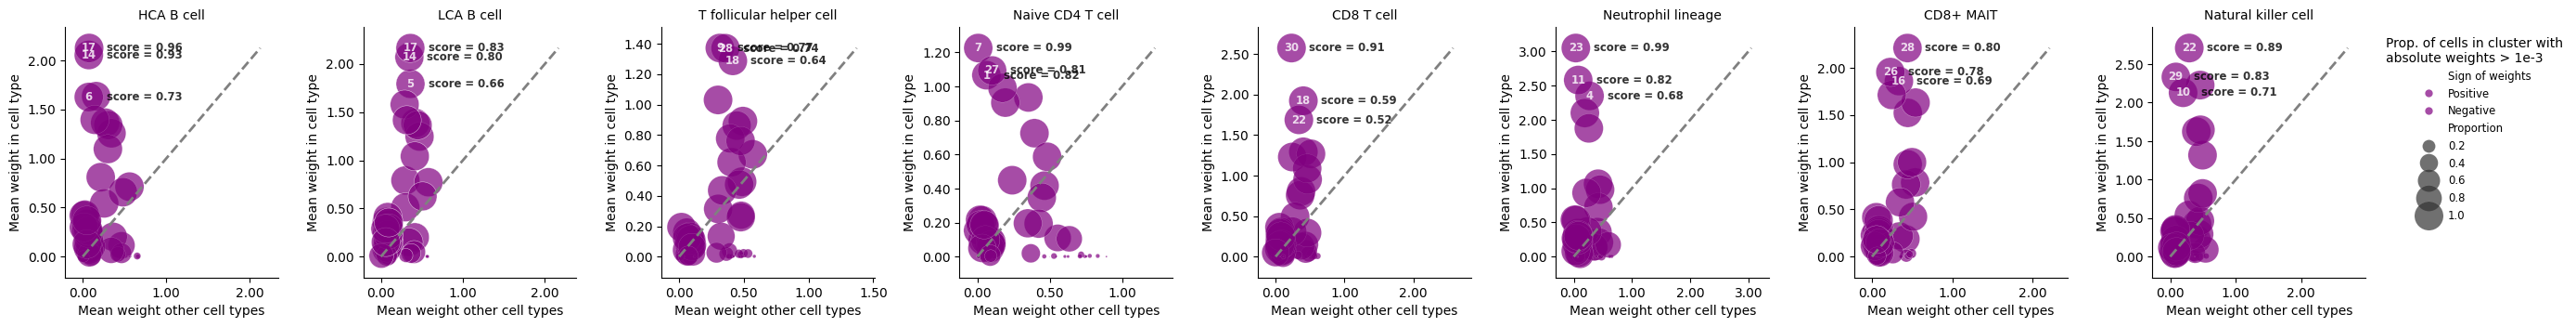

In [2]:
import muon as mu
import scanpy as sc


x = np.array(sc.read_h5ad('../datasets/GSE158013/GSE158013_rna.h5ad').to_df()).astype('float32')
feature = sc.read_h5ad('../datasets/GSE158013/GSE158013_rna.h5ad').var.index
feature = list(map(lambda x: x.replace('rna:','') ,feature))

mdata = sc.AnnData(x)
mdata.var['genes'] = feature

mdata.obsm["X_scMAGCA"] = np.array(pd.read_csv('../scripts/GSE158013/scMAGCA_embedding.csv',index_col=0))
mdata.obs["annotation_scMAGCA"] = np.array(pd.read_csv('../scripts/GSE158013/GSE158013_8_labels.csv')['celltypes'])

print(mdata)


# plot factor
clusters_dict = {
    "scMAGCA": ['HCA B cell','LCA B cell','T follicular helper cell','Naive CD4 T cell',
                'CD8 T cell','Neutrophil lineage','CD8+ MAIT','Natural killer cell'],
}
plot_bubbles(
    clusters_dict=clusters_dict,
    embedding_key={
        "scMAGCA":"X_scMAGCA"
    },
    annotation_key={
        "scMAGCA": "annotation_scMAGCA"
    },
    colors={
        "scMAGCA": ["purple"]
    }
) 

## Comparisonof clustering performance between scMAGCA and Seurat across different omics modalities on theTEA-seq dataset ‘GSE158013’.

In [1]:
library(anndata)
library(reticulate)
library(dplyr)
library(tidyr)
library(Seurat)
library(ggplot2)
library(reticulate)
library(Signac)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:anndata’:

    Layers


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
set.seed(0)
use_python("/home/zhouzeming/anaconda3/bin")
ad <- import("anndata")

In [3]:
adt <- ad$read_h5ad('../datasets/GSE158013/GSE158013_adt.h5ad')
atac <- ad$read_h5ad('../datasets/GSE158013/GSE158013_atac.h5ad')
rna <- ad$read_h5ad('../datasets/GSE158013/GSE158013_rna.h5ad')

scRNA.adt <- adt$X
scRNA.atac <- atac$X
scRNA.rna <- rna$X

colors <- c("B cell" = "#63cafe",
            "Naive CD4 T cell" = "#AEC7E8",
            "T follicular helper cell" = "#FFBB78",
            "CD8 T cell" = "#FF9896",
            "Natural killer cell" = "#bde39e",
            "CD8+ MAIT" = "#C49C94",
            "Neutrophil lineage" = "#C5B0D6")

### scMAGCA

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
16:11:32 UMAP embedding parameters a = 0.9922 b = 1.112

16:11:32 Read 7084 rows and found 30 numeric columns

16:11:32 Using Annoy for neighbor search, n_neighbors = 30

16:11:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:11:33 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c5f2f9327

16:11:33 Searching Annoy index using 1 thread, search_k = 3000

16:11:35 Annoy recall = 100%

16:11:36 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:11:37 Initializing from normalized Lapla

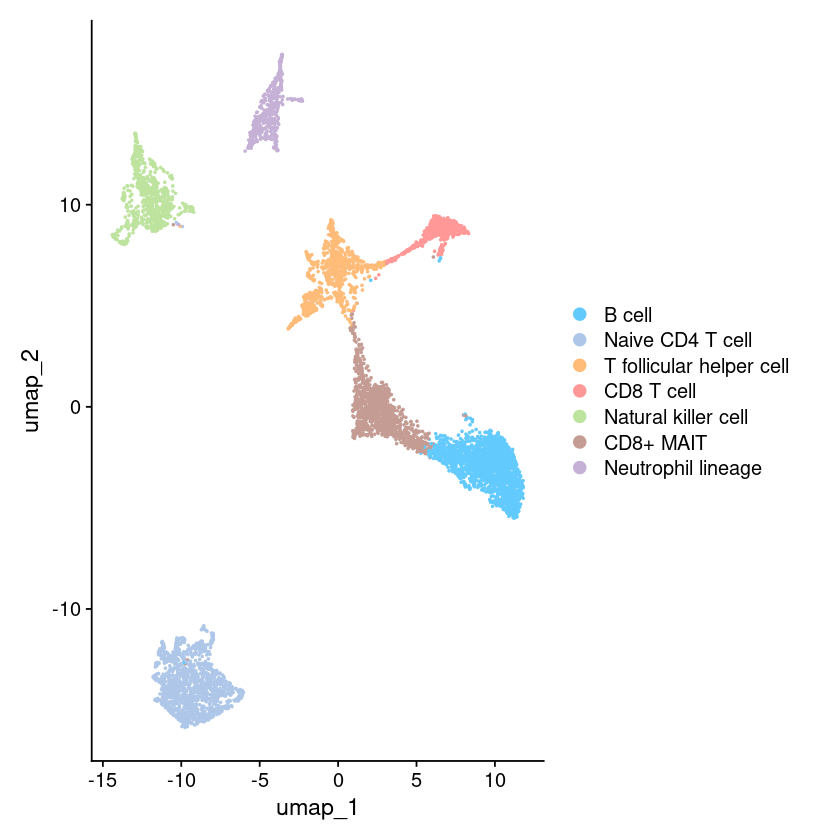

In [79]:
# scMAGCA:ADT
ADT <- CreateSeuratObject(counts = t(scRNA.adt),project ="ADT",min.cells = 3)
ADT_label <- read.csv("../scripts/GSE158013/scMAGCA_adt_pred.csv",header = F)
ADT@meta.data$clusters <- ADT_label
Idents(ADT) <- as.factor(ADT_label$V1)
ADT <- NormalizeData(ADT, normalization.method = "LogNormalize")
ADT <- FindVariableFeatures(ADT, selection.method = "vst", nfeatures = 2000) 
ADT <- ScaleData(ADT, features = rownames(ADT))
ADT_mds<- read.csv('../scripts/GSE158013/scMAGCA_adt_embedding.csv',row.names=1)
ADT_mds <- as.matrix(ADT_mds)
colnames(ADT_mds) <- paste0("MDS_", 1:32)
ADT[["mds"]] <- CreateDimReducObject(embeddings = ADT_mds, key = "MDS_", assay = DefaultAssay(ADT))
ADT <- RunUMAP(ADT,dims = 1:30,label=T,reduction = "mds")
new.cluster.ids <- c("B cell", "Naive CD4 T cell", "T follicular helper cell", "CD8 T cell", "Natural killer cell", "CD8+ MAIT", "Neutrophil lineage")
names(new.cluster.ids) <- levels(ADT)
ADT <- RenameIdents(ADT, new.cluster.ids)
DimPlot(ADT, reduction = "umap", label = F, cols = colors)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
16:12:17 UMAP embedding parameters a = 0.9922 b = 1.112

16:12:17 Read 7084 rows and found 30 numeric columns

16:12:17 Using Annoy for neighbor search, n_neighbors = 30

16:12:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:12:18 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c10bcf809

16:12:18 Searching Annoy index using 1 thread, search_k = 3000

16:12:20 Annoy recall = 100%

16:12:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:12:21 Initializing from normalized Lapla

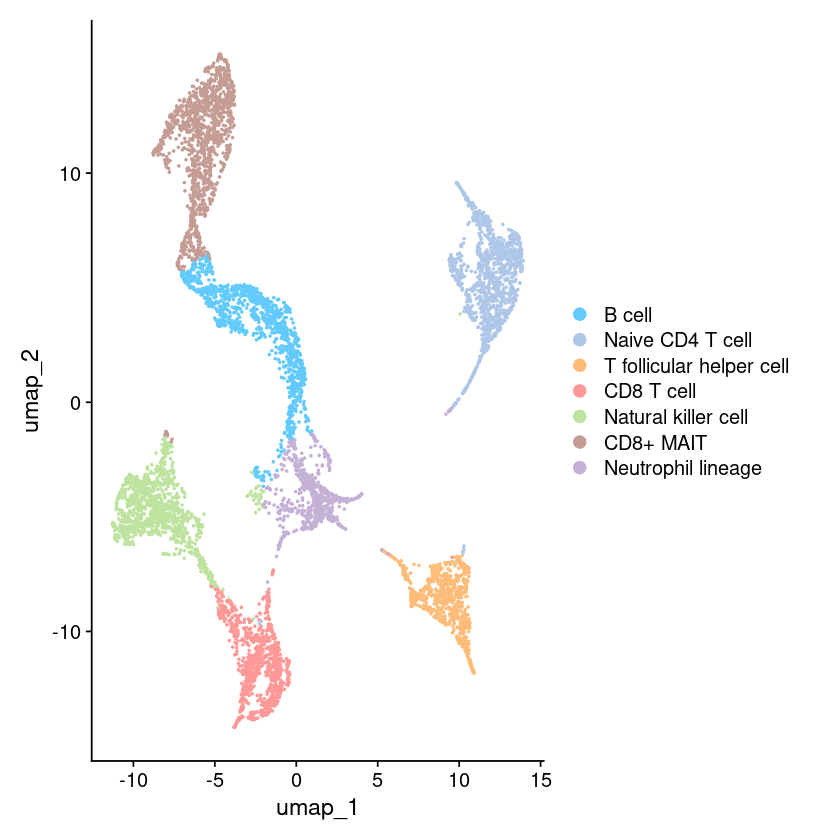

In [80]:
# scMAGCA:ATAC
ATAC <- CreateSeuratObject(counts = t(scRNA.atac),project ="ATAC",min.cells = 3)
ATAC_label <- read.csv("../scripts/GSE158013/scMAGCA_atac_pred.csv",header = F)
ATAC@meta.data$clusters <- ATAC_label
Idents(ATAC) <- as.factor(ATAC_label$V1)
ATAC <- NormalizeData(ATAC, normalization.method = "LogNormalize")
ATAC <- FindVariableFeatures(ATAC, selection.method = "vst", nfeatures = 2000) 
ATAC <- ScaleData(ATAC, features = rownames(ATAC))
ATAC_mds<- read.csv('../scripts/GSE158013/scMAGCA_atac_embedding.csv',row.names=1)
ATAC_mds <- as.matrix(ATAC_mds)
colnames(ATAC_mds) <- paste0("MDS_", 1:32)
ATAC[["mds"]] <- CreateDimReducObject(embeddings =ATAC_mds, key = "MDS_", assay = DefaultAssay(ATAC))
ATAC <- RunUMAP(ATAC,dims = 1:30,label=T,reduction = "mds")
new.cluster.ids <- c("B cell", "Naive CD4 T cell", "T follicular helper cell", "CD8 T cell", "Natural killer cell", "CD8+ MAIT", "Neutrophil lineage")
names(new.cluster.ids) <- levels(ATAC)
ATAC <- RenameIdents(ATAC, new.cluster.ids)
DimPlot(ATAC, reduction = "umap", label = F, cols = colors)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:20:26 UMAP embedding parameters a = 0.9922 b = 1.112

09:20:26 Read 7084 rows and found 30 numeric columns

09:20:26 Using Annoy for neighbor search, n_neighbors = 30

09:20:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:20:27 Writing NN index fil

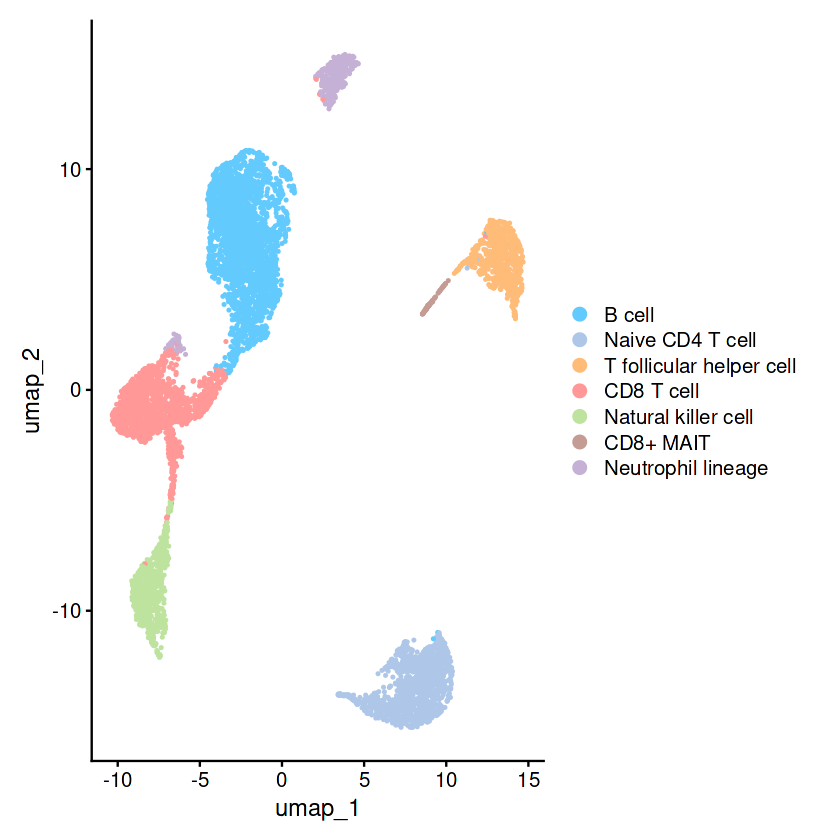

In [4]:
# scMAGCA:RNA
RNA <- CreateSeuratObject(counts = t(scRNA.rna),project ="RNA",min.cells = 3)
RNA_label <- read.csv("../scripts/GSE158013/scMAGCA_rna_pred.csv",header = F)
RNA@meta.data$clusters <- RNA_label
Idents(RNA) <- as.factor(RNA_label$V1)
RNA <- NormalizeData(RNA, normalization.method = "LogNormalize")
RNA <- FindVariableFeatures(RNA, selection.method = "vst", nfeatures = 2000) 
RNA <- ScaleData(RNA, features = rownames(RNA))
RNA_mds<- read.csv('../scripts/GSE158013/scMAGCA_rna_embedding.csv',row.names=1)
RNA_mds <- as.matrix(RNA_mds)
colnames(RNA_mds) <- paste0("MDS_", 1:32)
RNA[["mds"]] <- CreateDimReducObject(embeddings = RNA_mds, key = "MDS_", assay = DefaultAssay(RNA))
RNA <- RunUMAP(RNA,dims = 1:30,label=T,reduction = "mds")
new.cluster.ids <- c("B cell", "Naive CD4 T cell", "T follicular helper cell", "CD8 T cell", "Natural killer cell", "CD8+ MAIT", "Neutrophil lineage")
names(new.cluster.ids) <- levels(RNA)
RNA <- RenameIdents(RNA, new.cluster.ids)
DimPlot(RNA, reduction = "umap", label = F, cols = colors)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
16:15:23 UMAP embedding parameters a = 0.9922 b = 1.112

16:15:23 Read 7084 rows and found 30 numeric columns

16:15:23 Using Annoy for neighbor search, n_neighbors = 30

16:15:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:15:24 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54cedf3864

16:15:24 Searching Annoy index using 1 thread, search_k = 3000

16:15:26 Annoy recall = 100%

16:15:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:15:27 Initializing from normalized Laplac

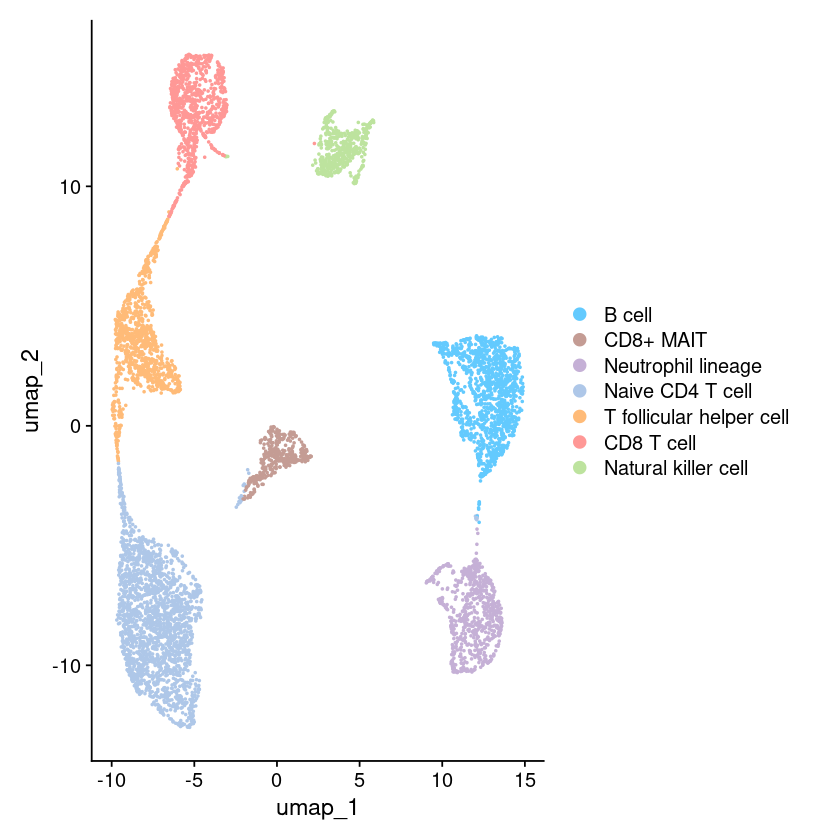

In [84]:
# scMAGCA:ADT+RNA
pbmc <- CreateSeuratObject(counts = t(scRNA.rna),project ="RNA",min.cells = 3)
label <- read.csv("../scripts/GSE158013/scMAGCA_adt_rna_pred.csv",header = F)
pbmc@meta.data$clusters <- label
Idents(pbmc) <- as.factor(label$V1)
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize")
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000) 
pbmc <- ScaleData(pbmc, features = rownames(pbmc))
pbmc_mds<- read.csv('../scripts/GSE158013/scMAGCA_adt_rna_embedding.csv',row.names=1)
pbmc_mds <- as.matrix(pbmc_mds)
colnames(pbmc_mds) <- paste0("MDS_", 1:32)
pbmc[["mds"]] <- CreateDimReducObject(embeddings = pbmc_mds, key = "MDS_", assay = DefaultAssay(pbmc))


new.cluster.ids <- c("B cell", 
                     "CD8+ MAIT", 
                     "Neutrophil lineage", 
                     "Naive CD4 T cell", 
                     "T follicular helper cell", 
                     "CD8 T cell", 
                     "Natural killer cell")


names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)

pbmc <- RunUMAP(pbmc,dims = 1:30,label=T,reduction = "mds")
DimPlot(pbmc, reduction = "umap", label = F, cols = colors)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
16:20:02 UMAP embedding parameters a = 0.9922 b = 1.112

16:20:02 Read 7084 rows and found 30 numeric columns

16:20:02 Using Annoy for neighbor search, n_neighbors = 30

16:20:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:20:03 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c632c09fa

16:20:03 Searching Annoy index using 1 thread, search_k = 3000

16:20:05 Annoy recall = 100%

16:20:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:20:07 Initializing from normalized Lapla

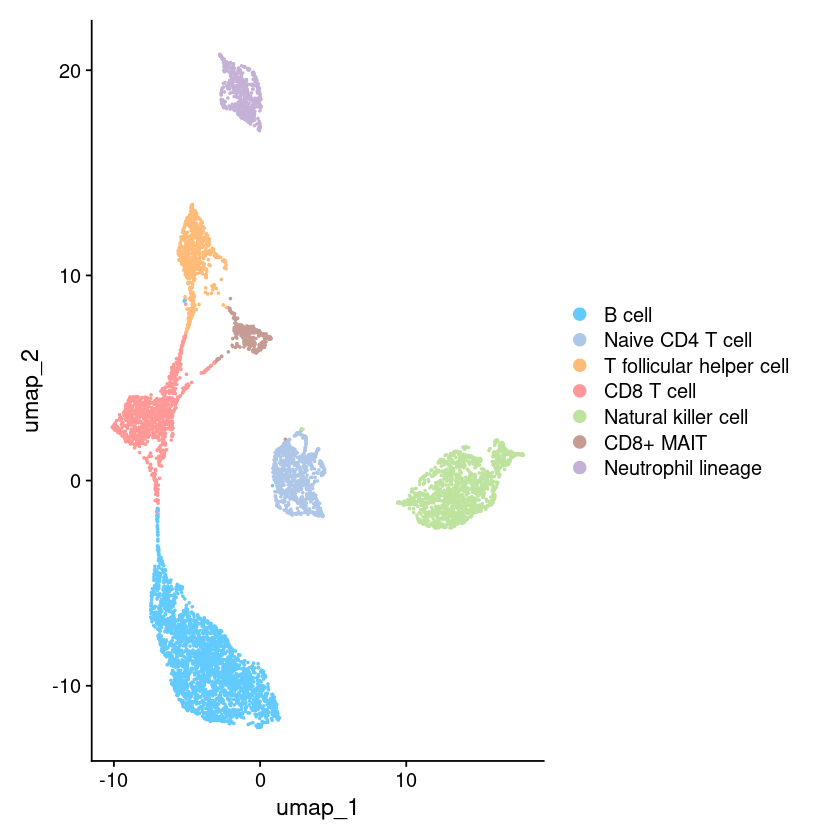

In [88]:
# scMAGCA:ATAC+RNA
pbmc <- CreateSeuratObject(counts = t(scRNA.rna),project ="RNA",min.cells = 3)
label <- read.csv("../scripts/GSE158013/scMAGCA_atac_rna_pred.csv",header = F)
pbmc@meta.data$clusters <- label
Idents(pbmc) <- as.factor(label$V1)
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize")
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000) 
pbmc <- ScaleData(pbmc, features = rownames(pbmc))
pbmc_mds<- read.csv('../scripts/GSE158013/scMAGCA_atac_rna_embedding.csv',row.names=1)
pbmc_mds <- as.matrix(pbmc_mds)
colnames(pbmc_mds) <- paste0("MDS_", 1:32)
pbmc[["mds"]] <- CreateDimReducObject(embeddings = pbmc_mds, key = "MDS_", assay = DefaultAssay(pbmc))
new.cluster.ids <- c("B cell", "Naive CD4 T cell", "T follicular helper cell", "CD8 T cell", "Natural killer cell", "CD8+ MAIT", "Neutrophil lineage")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
pbmc <- RunUMAP(pbmc,dims = 1:30,label=T,reduction = "mds")
DimPlot(pbmc, reduction = "umap", label = F, cols = colors)

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
16:20:40 UMAP embedding parameters a = 0.9922 b = 1.112

16:20:40 Read 7084 rows and found 32 numeric columns

16:20:40 Using Annoy for neighbor search, n_neighbors = 30

16:20:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:20:40 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c2f3f9aad

16:20:40 Searching Annoy index using 1 thread, search_k = 3000

16:20:42 Annoy recall = 100%

16:20:43 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:20:44 Initializing from normalized Lapla

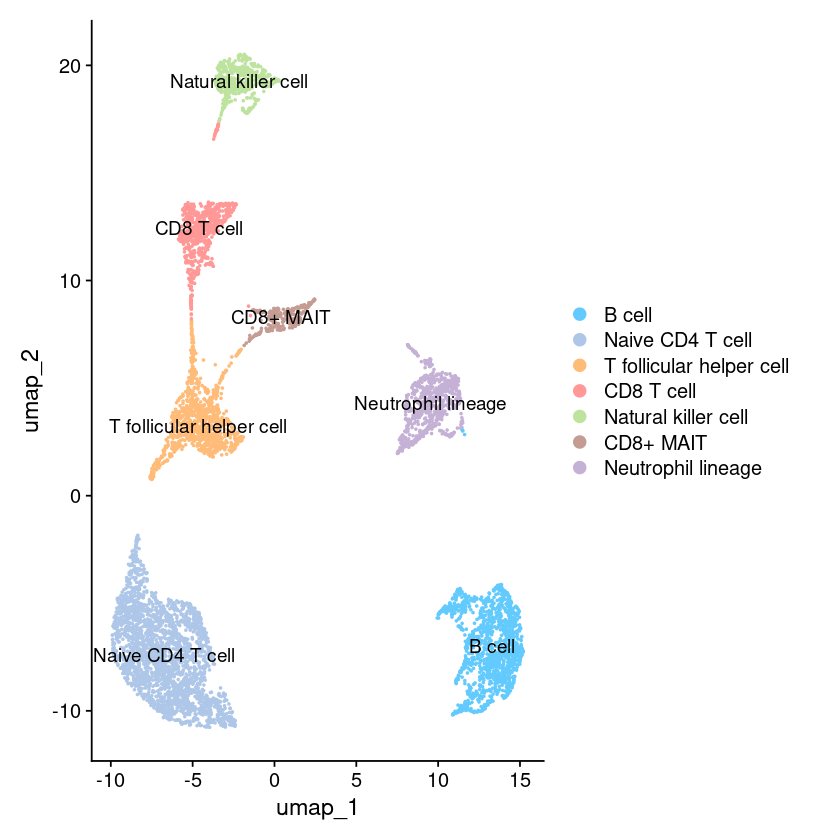

In [89]:
# scMAGCA:RNA+ADT+ATAC
scRNA <- CreateSeuratObject(counts = t(rna$X),project ="scRNA",min.cells = 3)
label <- read.csv("../scripts/GSE158013/scMAGCA_pred.csv",header = F)
scRNA@meta.data$clusters <- label
Idents(scRNA) <- as.factor(label$V1)
scRNA <- NormalizeData(scRNA, normalization.method = "LogNormalize")
scRNA <- FindVariableFeatures(scRNA, selection.method = "vst", nfeatures = 2000) 
scRNA <- ScaleData(scRNA, features = rownames(scRNA))
variable.genes <- head(VariableFeatures(scRNA), 2000)

mds<- read.csv('../scripts/GSE158013/scMAGCA_embedding.csv',row.names=1)
mds <- as.matrix(mds)
colnames(mds) <- paste0("MDS_", 1:32)
scRNA[["mds"]] <- CreateDimReducObject(embeddings = mds, key = "MDS_", assay = DefaultAssay(scRNA))
scRNA <- RunUMAP(scRNA,dims = 1:32,label=T,reduction = "mds")

scRNA.markers <- FindAllMarkers(scRNA, 
                                ident.col = "clusters",
                                only.pos = T,  
                                min.pct = 0.25, 
                                logfc.threshold = 0.25,
                                features = variable.genes)
top.markers <- scRNA.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

new.cluster.ids <- c("B cell", "Naive CD4 T cell", "T follicular helper cell", "CD8 T cell", "Natural killer cell", "CD8+ MAIT", "Neutrophil lineage")
names(new.cluster.ids) <- levels(scRNA)
scRNA <- RenameIdents(scRNA, new.cluster.ids)
Joint_umap <-DimPlot(scRNA, reduction = "umap", label = TRUE, cols = colors)

Joint_umap

### Seurat

In [5]:
adt1 <- t(ad$read_h5ad('../datasets/GSE158013/GSE158013_adt.h5ad'))
atac1 <- t(ad$read_h5ad('../datasets/GSE158013/GSE158013_atac.h5ad'))
rna1 <- t(ad$read_h5ad('../datasets/GSE158013/GSE158013_rna.h5ad'))

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
PC_ 1 
Po

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7084
Number of edges: 233863

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8538
Number of communities: 7
Elapsed time: 0 seconds


16:21:48 UMAP embedding parameters a = 0.9922 b = 1.112

16:21:48 Read 7084 rows and found 10 numeric columns

16:21:48 Using Annoy for neighbor search, n_neighbors = 30

16:21:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:21:48 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c5f894291

16:21:48 Searching Annoy index using 1 thread, search_k = 3000

16:21:51 Annoy recall = 100%

16:21:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:21:53 Initializing from normalized Laplacian + noise (using RSpectra)

16:21:53 Commencing optimization for 500 epochs, with 281268 positive edges

16:21:53 Using rng type: pcg

16:22:01 Optimization finished



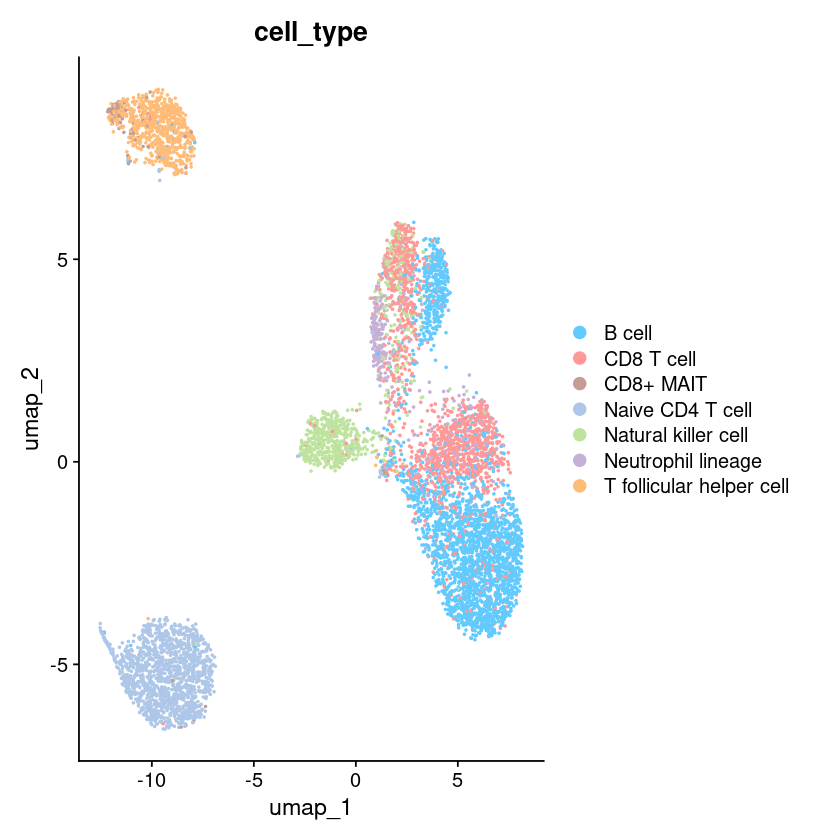

In [90]:
# Seurat:ADT
pbmc<-CreateSeuratObject(counts = adt1$layers['counts'])
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc)
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(pbmc))
pbmc <- FindNeighbors(pbmc, dims = 1:10) 
pbmc <- FindClusters(pbmc, resolution = 0.6)
pbmc <- RunUMAP(pbmc, dims = 1:10)

RNA$cell_type <- Idents(RNA)
RNA$cells <- rownames(RNA@meta.data)
rnadata <- RNA@meta.data
rnadata$cell_type <- as.character(rnadata$cell_type)

pbmc$cells <- rownames(pbmc@meta.data)
pbmc$cell_type <- NA
matching_indices <- match(pbmc$cells, rnadata$cells)
pbmc$cell_type[!is.na(matching_indices)] <-rnadata$cell_type[matching_indices[!is.na(matching_indices)]]

DimPlot(pbmc, reduction = "umap", label = F, cols = colors, group.by = "cell_type")

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  atac:chr12:120011680-120015691, atac:chr22:37147189-37150674, atac:chr2:241762294-241764484, atac:chr22:39089958-39092703, atac:chr2:29009466-29013363, atac:chr20:38872579-38876222, atac:chr19:10796878-10798373, atac:chr22:37161378-37165123, atac:chr17:3794780-3797254, atac:chr9:129866220-129870482 
	   atac:chr2:221517267-221519080, atac:chr12:121557387-121558559, atac:chr16:88619429-88620894, atac:chr14:101711255-101714135, atac:chr4:8408925-8410213, atac:chr2:86785355-86787189, atac:chr1:6459524-6461313, atac:chr10:132158175-132162575, atac:chr10:73758804-73760269, atac:chr15:39623300-39625381 
	   atac:chr10:8416067-8417285, atac:chr21:46423849-46426323, atac:chr8:20251545-20252505, atac:chr4:6198109-6202085, atac:chr20:33369220-33370897, atac:chr10:70602440-70604014, atac:chr9:89501494-89503014, atac:chr13:24618017-24619199, atac:chr20:24959642-24961756, atac

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7084
Number of edges: 235169

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9449
Number of communities: 7
Elapsed time: 0 seconds


16:23:13 UMAP embedding parameters a = 0.9922 b = 1.112

16:23:13 Read 7084 rows and found 10 numeric columns

16:23:13 Using Annoy for neighbor search, n_neighbors = 30

16:23:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:23:13 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c593ebb06

16:23:13 Searching Annoy index using 1 thread, search_k = 3000

16:23:16 Annoy recall = 100%

16:23:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:23:18 Initializing from normalized Laplacian + noise (using RSpectra)

16:23:18 Commencing optimization for 500 epochs, with 296064 positive edges

16:23:18 Using rng type: pcg

16:23:26 Optimization finished



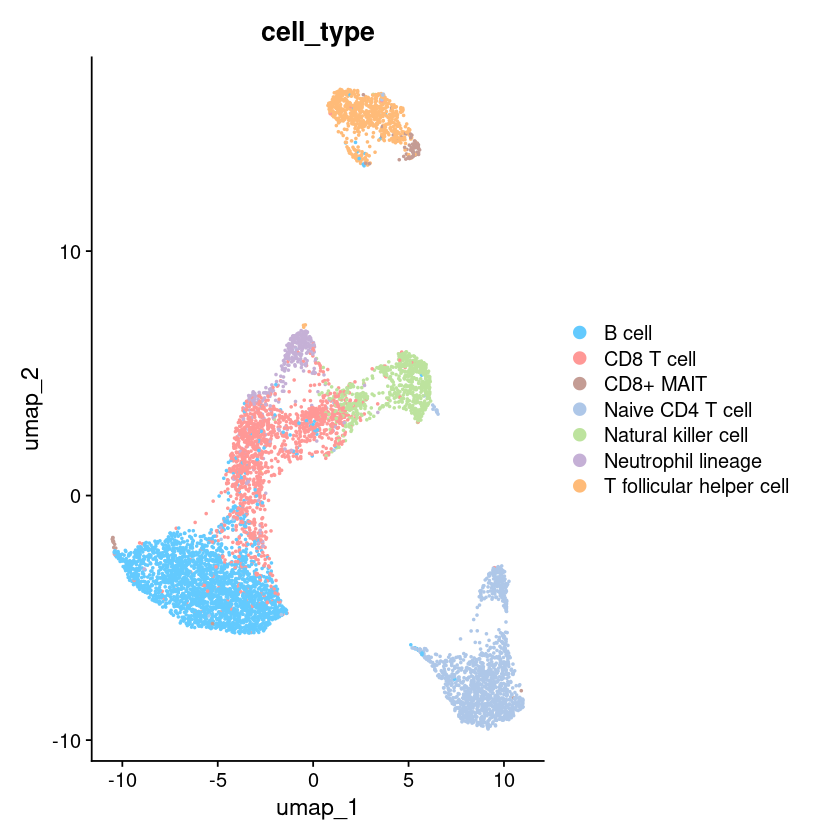

In [92]:
# Seurat:ATAC
pbmc<-CreateSeuratObject(counts = atac1$layers['counts'])
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc)
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(pbmc))
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.2)
pbmc <- RunUMAP(pbmc, dims = 1:10)

RNA$cell_type <- Idents(RNA)
RNA$cells <- rownames(RNA@meta.data)
rnadata <- RNA@meta.data
rnadata$cell_type <- as.character(rnadata$cell_type)

pbmc$cells <- rownames(pbmc@meta.data)
pbmc$cell_type <- NA
matching_indices <- match(pbmc$cells, rnadata$cells)
pbmc$cell_type[!is.na(matching_indices)] <-rnadata$cell_type[matching_indices[!is.na(matching_indices)]]

DimPlot(pbmc, reduction = "umap", label = F, cols = colors, group.by = "cell_type")

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  rna:BANK1, rna:MS4A1, rna:ADAM28, rna:CDK14, rna:ARHGAP24, rna:TRIO, rna:FCRL1, rna:COL19A1, rna:PAX5, rna:GNG7 
	   rna:EBF1, rna:WDFY4, rna:CD22, rna:RUBCNL, rna:COBLL1, rna:IGHM, rna:AFF3, rna:LINC00926, rna:PLEKHG1, rna:HLA-DRB1 
	   rna:LYN, rna:HLA-DQB1, rna:MEF2C, rna:PALM2-AKAP2, rna:SWAP70, rna:OSBPL10, rna:LARGE1, rna:LIX1-AS1, rna:KHDRBS2, rna:FCER2 
Negative:  rna:PRKCH, rna:CD247, rna:RORA, rna:CDC14A, rna:TNFAIP3, rna:CAMK4, rna:INPP4B, rna:PDE3B, rna:BTBD11, rna:LEF1 
	   rna:GPRIN3, rna:GATA3, rna:YES1, rna:NELL2, rna:BICDL1, rna:PBX4, rna:MALAT1, rna:PLCL1, rna:ID2, rna:TSHZ2 
	   rna:THEMIS, rna:GNG2, rna:MLLT3, rna:TGFBR3, rna:TAFA1, rna:NCALD, rna:ANXA1, rna:ADAMTSL4-AS1, rna:PCSK5, rna:GNAQ 
PC_ 2 
Positive:  rna:SLC11A1, rna:ITGAX, rna:LRMDA, rna:CSF2RA, rna:CSF3R, rna:RBM47, rna:SULF2, rna:PLAUR, rna:PLXDC2, rna:PID1 
	   rna:EEPD1, rna:FCN1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7084
Number of edges: 245390

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9498
Number of communities: 7
Elapsed time: 0 seconds


16:24:00 UMAP embedding parameters a = 0.9922 b = 1.112

16:24:00 Read 7084 rows and found 10 numeric columns

16:24:00 Using Annoy for neighbor search, n_neighbors = 30

16:24:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:24:01 Writing NN index file to temp file /tmp/RtmpqedK00/file3fa54c443d307

16:24:01 Searching Annoy index using 1 thread, search_k = 3000

16:24:03 Annoy recall = 100%

16:24:04 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:24:05 Initializing from normalized Laplacian + noise (using RSpectra)

16:24:05 Commencing optimization for 500 epochs, with 292336 positive edges

16:24:05 Using rng type: pcg

16:24:13 Optimization finished



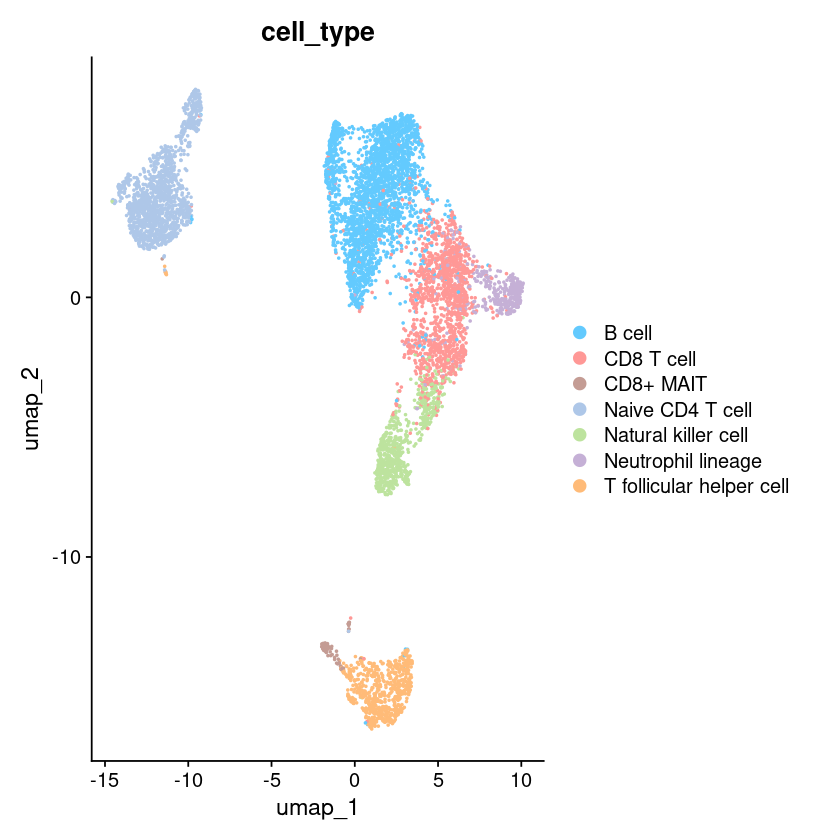

In [93]:
# Seurat:RNA
pbmc<-CreateSeuratObject(counts = rna1$layers['counts'])
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc)
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(pbmc))
pbmc <- FindNeighbors(pbmc, dims = 1:10) 
pbmc <- FindClusters(pbmc, resolution = 0.18)
pbmc <- RunUMAP(pbmc, dims = 1:10)

RNA$cell_type <- Idents(RNA)
RNA$cells <- rownames(RNA@meta.data)
rnadata <- RNA@meta.data
rnadata$cell_type <- as.character(rnadata$cell_type)

pbmc$cells <- rownames(pbmc@meta.data)
pbmc$cell_type <- NA
matching_indices <- match(pbmc$cells, rnadata$cells)
pbmc$cell_type[!is.na(matching_indices)] <-rnadata$cell_type[matching_indices[!is.na(matching_indices)]]

DimPlot(pbmc, reduction = "umap", label = F, cols = colors, group.by = "cell_type")

[1] "RNA"

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing across cells

Centering and scaling data matrix

Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
PC_ 1 
Positive

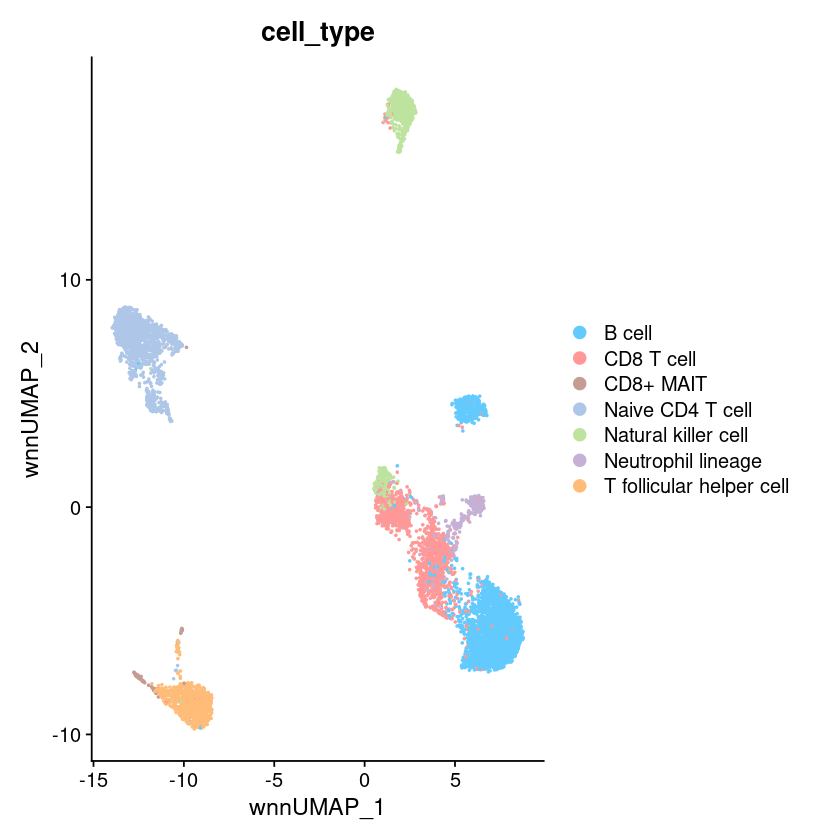

In [56]:
# ADT+RNA
pbmc<-CreateSeuratObject(counts = rna1$layers['counts'])
Assays(pbmc)

adt_assay<-CreateAssayObject(counts = adt1$layers['counts'])
pbmc[["ADT"]]<-adt_assay

DefaultAssay(pbmc) <- "RNA"
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc)
pbmc <- ScaleData(pbmc)
pbmc <- RunPCA(pbmc, verbose = FALSE)

DefaultAssay(pbmc) <- "ADT"
VariableFeatures(pbmc) <- rownames(pbmc[["ADT"]])
pbmc <- NormalizeData(pbmc, normalization.method = 'CLR', margin = 2)
pbmc <- ScaleData(pbmc)
pbmc <- RunPCA(pbmc, reduction.name = 'adtpca')

pbmc <- FindMultiModalNeighbors(
  pbmc, reduction.list = list("adtpca", "pca"),
  dims.list = list(1:18, 1:30), modality.weight.name = "RNA.weight"
)

pbmc <- RunUMAP(pbmc, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
pbmc <- FindClusters(pbmc, graph.name = "wsnn", algorithm = 3, resolution = 0.07, verbose = FALSE)

RNA$cell_type <- Idents(RNA)
RNA$cells <- rownames(RNA@meta.data)
rnadata <- RNA@meta.data
rnadata$cell_type <- as.character(rnadata$cell_type)

pbmc$cells <- rownames(pbmc@meta.data)
pbmc$cell_type <- NA
matching_indices <- match(pbmc$cells, rnadata$cells)
pbmc$cell_type[!is.na(matching_indices)] <-rnadata$cell_type[matching_indices[!is.na(matching_indices)]]

DimPlot(pbmc, reduction = "wnn.umap", label = F, cols = colors, group.by = "cell_type")

[1] "RNA"

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, layer = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings

09:26:50 UMAP embedding parameters a = 0.9922 b = 1.112

09:26:50 Read 7084 rows and found 49 numeric columns

09:26:50 Using Annoy for neighbor search, n_neighbors = 30

09:26:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:26:50 Writing NN index file to temp file /tmp/Rtmp9HRlb7/filef24c93a2d75d0

09:26:50 Searching Annoy index using 1 thread, search_k = 3000

09:26:53 Annoy recall = 100%

09:26:53 Commencing smooth kNN distance calibration using 1 thread

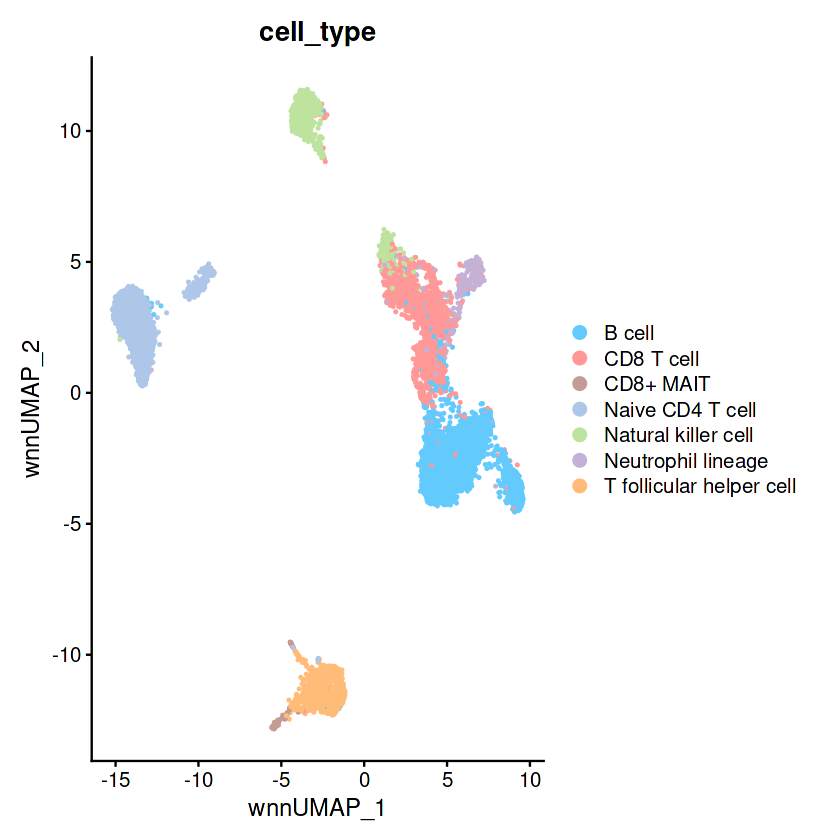

In [13]:
# ATAC+RNA
pbmc<-CreateSeuratObject(counts = rna1$layers['counts'])
Assays(pbmc)

atac_assay<-CreateAssayObject(counts = atac1$layers['counts'])
pbmc[["ATAC"]]<-atac_assay

DefaultAssay(pbmc) <- "RNA"
pbmc <- NormalizeData(pbmc)
pbmc <- FindVariableFeatures(pbmc)
pbmc <- ScaleData(pbmc)
pbmc <- RunPCA(pbmc, verbose = FALSE)

DefaultAssay(pbmc) <- "ATAC"
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc)
pbmc <- RunSVD(pbmc)
pbmc <- RunUMAP(pbmc, reduction = 'lsi', dims = 2:50, reduction.name = "atacpca", reduction.key = "atacUMAP_")

pbmc <- FindMultiModalNeighbors(
  pbmc, reduction.list = list("lsi", "pca"),
  dims.list = list(2:50, 1:30), modality.weight.name = "RNA.weight"
)

pbmc <- RunUMAP(pbmc, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
pbmc <- FindClusters(pbmc, graph.name = "wsnn", algorithm = 3, resolution = 0.078, verbose = FALSE)

RNA$cell_type <- Idents(RNA)
RNA$cells <- rownames(RNA@meta.data)
rnadata <- RNA@meta.data
rnadata$cell_type <- as.character(rnadata$cell_type)

pbmc$cells <- rownames(pbmc@meta.data)
pbmc$cell_type <- NA
matching_indices <- match(pbmc$cells, rnadata$cells)
pbmc$cell_type[!is.na(matching_indices)] <-rnadata$cell_type[matching_indices[!is.na(matching_indices)]]

DimPlot(pbmc, reduction = "wnn.umap", label = F, cols = colors, group.by = "cell_type")

[1] "RNA"

[1] "RNA"  "ADT"  "ATAC"

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing across cells

Centering and scaling data matrix

Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in svd.function(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
Warning message:
“Requested number is larger than the number of available items (46). Setting to 46.”
PC_ 1 
Positive

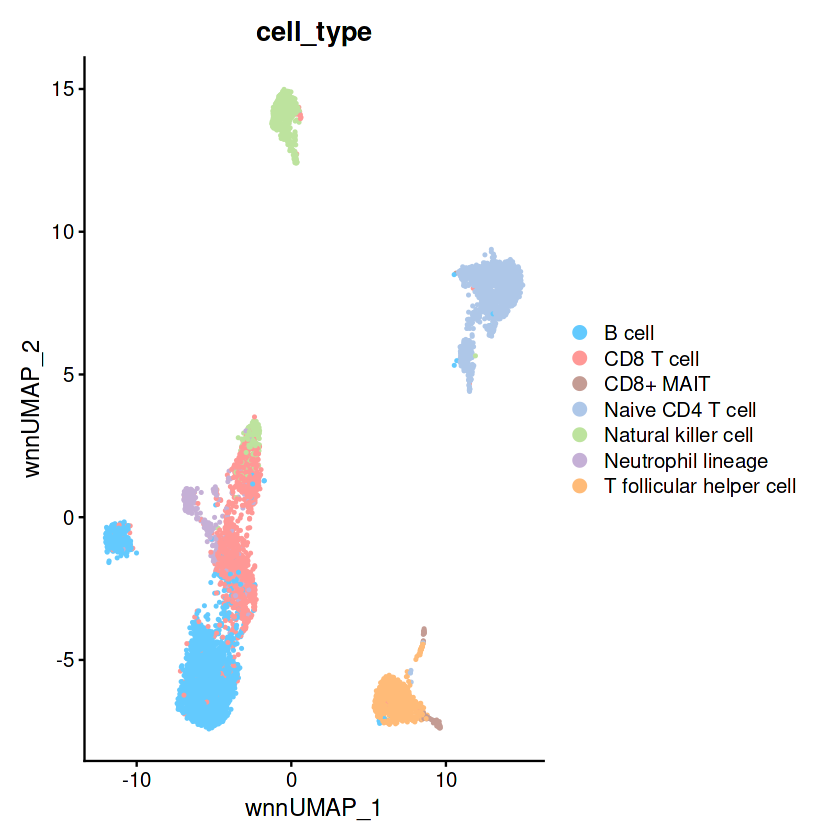

In [16]:
assay<-CreateSeuratObject(counts = rna1$layers['counts'])
Assays(assay)

adt_assay<-CreateAssayObject(counts = adt1$layers['counts'])
assay[["ADT"]]<-adt_assay
atac_assay<-CreateAssayObject(counts = atac1$layers['counts'])
assay[["ATAC"]]<-atac_assay
Assays(assay)


DefaultAssay(assay) <- "RNA"
assay <- NormalizeData(assay)
assay <- FindVariableFeatures(assay)
assay <- ScaleData(assay)
assay <- RunPCA(assay, verbose = FALSE)


DefaultAssay(assay) <- "ADT"
VariableFeatures(assay) <- rownames(assay[["ADT"]])
assay <- NormalizeData(assay, normalization.method = 'CLR', margin = 2)
assay <- ScaleData(assay)
assay <- RunPCA(assay, reduction.name = 'adtpca')


DefaultAssay(assay) <- "ATAC"
assay <- RunTFIDF(assay)
assay <- FindTopFeatures(assay)
assay <- RunSVD(assay)
assay <- RunUMAP(assay, reduction = 'lsi', dims = 2:50, reduction.name = "atacpca", reduction.key = "atacUMAP_")


assay <- FindMultiModalNeighbors(
  assay, reduction.list = list("adtpca", "lsi", "pca"),
  dims.list = list(1:18, 2:50, 1:30), modality.weight.name = "RNA.weight"
)

assay <- RunUMAP(assay, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
assay <- FindClusters(assay, graph.name = "wsnn", algorithm = 3, resolution = 0.07, verbose = FALSE)

RNA$cell_type <- Idents(RNA)
RNA$cells <- rownames(RNA@meta.data)
rnadata <- RNA@meta.data
rnadata$cell_type <- as.character(rnadata$cell_type)

assay$cells <- rownames(assay@meta.data)
assay$cell_type <- NA
matching_indices <- match(assay$cells, rnadata$cells)
assay$cell_type[!is.na(matching_indices)] <-rnadata$cell_type[matching_indices[!is.na(matching_indices)]]

DimPlot(assay, reduction = "wnn.umap", label = F, cols = colors, group.by = "cell_type")

GO and KEGG enrichment analysis of the top genes from the HCA B cell-specific latent factor 6 identified by scMAGCA using the 'enrichGO' and 'enrichKEGG' functions. FDR, Benjamini Hochberg adjusted P values, were transformed as -log10(FDR) for visualization.

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“11% of input gene IDs are fail to map...”
Warning message in geom_segment(aes(x = 0, y = 0, xend = xaxis_max, yend = 0), linewidth = 1.5, :
“All aesthetics have length 1, but the data has 14 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_segment(aes(x = 0, y = 0, xend = xaxis_max, yend = 0), linewidth = 1.5, :
“All aesthetics have length 1, but the data has 14 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”


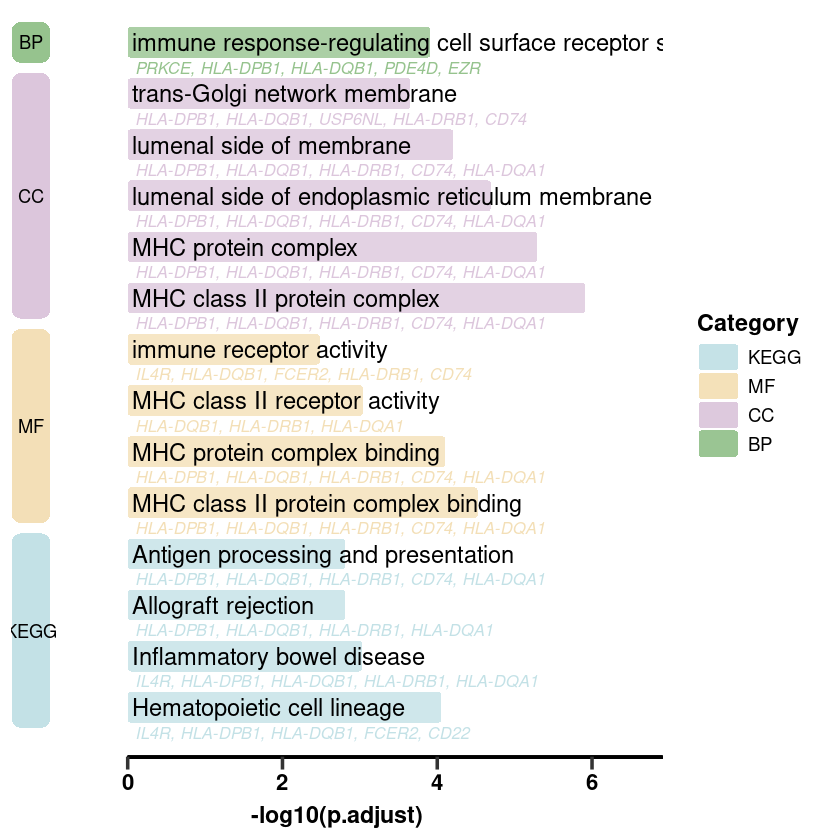

In [69]:
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(org.Hs.eg.db)
GO_database <- org.Hs.eg.db


# HCA B
genes <- c('HSPB1', 'LINC01146', 'MAK', 'AC108879.1', 'JARID2', 'RGS7', 'PRKCE', 'RCSD1', 'APLP2', 'GNA12', 'SEL1L3', 'ADAM28', 'ATF7IP', 'ADK', 'IL4R', 'HLA-DPB1', 'ST6GAL1', 'AC024588.1', 'RAD9A', 'CEMIP2', 'EIF2AK3', 'ITPR1', 'ST6GALNAC3', 'TANK', 'TTTY10', 'LINC00926', 'HLA-DQB1', 'TTTY14', 'MTSS1', 'MGAT5', 'ZCCHC7', 'ABCA1', 'C12orf42', 'PDE4D', 'SYN3', 'CD83', 'EZR', 'AFF3', 'LYN', 'NUDT9', 'FCER2', 'STRBP', 'SSBP2', 'UACA', 'IMMP2L', 'LINC01340', 'BACH2', 'LIX1-AS1', 'AGPAT5', 'TRIO', 'SCN3A', 'CHST11', 'RERE', 'FCRL1', 'SIPA1L1', 'AL024507.2', 'COBLL1', 'AC068643.1', 'PACS1', 'PALM2-AKAP2', 'SNX29', 'AC120193.1', 'IFNG-AS1', 'AC008443.5', 'TPST1', 'FAM3C', 'MICAL3', 'SLC9B1', 'YBX3', 'RAD51B', 'USP6NL', 'DLG2', 'GNG7', 'KHDRBS2', 'DEC1', 'STEAP1B', 'COL19A1', 'ARID5B', 'ZNF532', 'AL512603.2', 'CD22', 'CEP41', 'ZBTB16', 'ZEB1', 'BANK1', 'VAV3', 'HLA-DRB1', 'MARCH1', 'AKAP6', 'CD74', 'RASGRP3', 'HLA-DQA1', 'SMAP2', 'PAX5', 'CCDC62', 'LARGE1', 'IRAK3', 'RHBDD1', 'ABCB1', 'NETO1') 
# LCA B
#genes <- c('ESR2', 'PTPRG', 'WDFY4', 'TTC9', 'YARS2', 'CTNNA3', 'CDKL1', 'AC109492.1', 'KIAA1958', 'PAX5', 'HLA-DRB1', 'GSTCD', 'ANK3', 'IL15RA', 'GAS2', 'RPS6KA2', 'AP1S3', 'DLG5', 'COL4A3', 'PSD3', 'ADD3-AS1', 'CSGALNACT1', 'BANK1', 'DST', 'STS', 'AP000763.3', 'ADCY3', 'HLA-DQA1', 'AC007780.1', 'BICD1', 'LINC01237', 'AC027682.4', 'RBMS3', 'PALM2-AKAP2', 'PPFIBP2', 'CALN1', 'LINC00926', 'KCNH8', 'GFRA2', 'C12orf42', 'ST6GAL1', 'MAPRE2', 'TRAP1', 'AC027097.2', 'TRIO', 'EMILIN2', 'SKI', 'SLC38A11', 'ARHGEF10', 'ADAM28', 'CHN1', 'SETBP1', 'RHBDD1', 'MNDA', 'FAM49A', 'MIR155HG', 'ARHGAP19', 'ZNF544', 'PRKX', 'IFNG-AS1', 'GFPT2', 'HHAT', 'AC008892.1', 'TFEC', 'GZMB', 'PAPSS1', 'MYO9A', 'IER3', 'EPHA1-AS1', 'SPRY1', 'CPPED1', 'ETV6', 'ARHGAP24', 'WDR64', 'MYO9B', 'COL4A4', 'PTK2', 'CD74', 'HLA-DRA', 'COBLL1', 'CNTNAP2', 'JAM3', 'TANK', 'JAZF1', 'IMMP2L', 'MGAT5', 'LINC00534', 'AC009522.1', 'IGHA2', 'CCL3', 'NFU1', 'PBX3', 'COX19', 'FCGR3A', 'NUMBL', 'AC120193.1', 'GPM6A', 'COX10-AS1', 'HIST1H2BD', 'BTD')

#KEGG_database <- 'mmu'
#GO_database <- org.db.eg.db

gene_entrez <- bitr(genes, fromType ="SYMBOL", toType ="ENTREZID", OrgDb = org.Hs.eg.db)

ego_all <- enrichGO(gene = gene_entrez$ENTREZID,
                    OrgDb = org.Hs.eg.db,
                    keyType ="ENTREZID",
                    ont ="ALL",
                    pAdjustMethod ="BH",
                    pvalueCutoff =0.05,
                    qvalueCutoff =0.05)

ekegg_all <- enrichKEGG(gene = gene_entrez$ENTREZID,
                        organism = "hsa", 
                        pvalueCutoff =0.05,
                        pAdjustMethod ="BH")

if(!is.null(ego_all)) write.csv(ego_all@result,"../scripts/GSE158013/GO_enrichment_all.csv")
if(!is.null(ekegg_all)) write.csv(ekegg_all@result,"../scripts/GSE158013/KEGG_enrichment_all.csv")

library(devtools)
library(gground)
library(ggprism)
library(tidyverse)
library(org.Hs.eg.db)    
library(clusterProfiler)

pal <- c('#c3e1e6','#f3dfb7','#dcc6dc','#96c38e')

ego_readable <- setReadable(
  ego_all,
  OrgDb   = org.Hs.eg.db,
  keyType = "ENTREZID"
)
GO <- as.data.frame(ego_readable)

ekegg_readable <- setReadable(
  ekegg_all,
  OrgDb   = org.Hs.eg.db,
  keyType = "ENTREZID"
)
KEGG <- as.data.frame(ekegg_readable)

use_pathway <- GO %>%
  group_by(ONTOLOGY) %>%
  top_n(5, wt = -p.adjust) %>%          
  group_by(p.adjust) %>%
  top_n(1, wt = Count) %>%                
  ungroup() %>%
  bind_rows(
    KEGG %>%
      top_n(5, wt = -p.adjust) %>%       
      group_by(p.adjust) %>%
      top_n(1, wt = Count) %>%
      ungroup() %>%
      mutate(ONTOLOGY = "KEGG")
  ) %>%
  mutate(
    ONTOLOGY = factor(ONTOLOGY,
                      levels = rev(c("BP","CC","MF","KEGG")))
  ) %>%
  dplyr::arrange(ONTOLOGY, p.adjust) %>%
  mutate(
    Description = factor(Description, levels = Description),
    index       = dplyr::row_number()
  ) %>%

  mutate(
    repGenes = sapply(
      strsplit(as.character(geneID), "/"),
      function(x) {
        x <- unique(x)
        paste(head(x, 5), collapse = ", ")
      }
    ),
    repGenes = stringr::str_trunc(repGenes, width = 60, side = "right")
  )

width     <- 0.5
xaxis_max <- max(-log10(use_pathway$p.adjust)) + 1

rect.data <- use_pathway %>%
  group_by(ONTOLOGY) %>%
  summarize(n = n(), .groups = "drop") %>%
  mutate(
    xmin = -3 * width,
    xmax = -2 * width,
    ymax = cumsum(n),
    ymin = dplyr::lag(ymax, default = 0) + 0.6,
    ymax = ymax + 0.4
  )

plot_enrichment <- function() {
  p <- use_pathway %>%
    ggplot(aes(-log10(p.adjust), y = index, fill = ONTOLOGY)) +
    geom_round_col(
      aes(y = Description), width = 0.6, alpha = 0.8
    ) +
    geom_text(
      aes(x = 0.05, label = Description),
      hjust = 0, size = 5
    ) +
    geom_text(
      aes(x = 0.1, label = repGenes, colour = ONTOLOGY),
      hjust = 0, vjust = 2.6, size = 3.5, fontface = "italic",
      show.legend = FALSE
    ) +
    geom_round_rect(
      aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax,
          fill = ONTOLOGY),
      data = rect.data,
      radius = unit(2,"mm"),
      inherit.aes = FALSE
    ) +
    geom_text(
      aes(x = (xmin + xmax) / 2,
          y = (ymin + ymax) / 2,
          label = ONTOLOGY),
      data = rect.data,
      inherit.aes = FALSE
    ) +
    geom_segment(
      aes(x = 0, y = 0, xend = xaxis_max, yend = 0),
      linewidth = 1.5,
      inherit.aes = FALSE
    ) +
    labs(y = NULL) +
    scale_fill_manual(name = "Category", values = pal) +
    scale_colour_manual(values = pal) +
    scale_x_continuous(
      breaks = seq(0, xaxis_max, 2),
      expand = expansion(c(0, 0))
    ) +
    theme_prism() +
    theme(
      axis.text.y  = element_blank(),
      axis.line    = element_blank(),
      axis.ticks.y = element_blank(),
      legend.title = element_text()
    )
  return(p)
}

enrichment_plot <- plot_enrichment()

ggsave(
  filename = "../scripts/GSE158013/HCA_factor_5go_genes_FDR.pdf",
  plot     = enrichment_plot,
  width    = 10,
  height   = 6
)
enrichment_plot